# An Rk4 Method to Modelling the Rowing Motion and Illustrating the Efficacy of Distinct Force Curves

##### Thomas Monahan


### Introduction:
Despite the repetitive nature of the rowing stroke, generating a realistic model of the rowing stroke is quite difficult. One must consider in addition to the physical influence of the rowers how drag and other natural phenomena influence both the propulsion and the acceleration of the boat. The purpose of my project is two-fold, first is to generate a realistic model of the rowing stroke that can be easily manipulated. Second, is to design power functions that can be inputted into the model and test them for their efficacy. The following code is based off of the mathematical model presented in "Modelling the Rowing Stroke" by Elke Ottenhoff. Before delving into the code, I need to acknowledge the limitations of this model. While this model takes into account the most significant forces present in the rowing stroke certain forces are neglected. For instance, wind resistance also serves to mitigate the speed of the boat. In comparison to the drag of water this force is not particularly significant, however, it is an example of a possible source of error between this theoretical model and any experimental data. Additionally, this model assumes that all 8 rowers have identical power curves and all can transfer their theoretical power into the boat simultaneously. Arguably just as significant as a rower's fitness and ability to output power is a rower's technique. Top level rowers spend decades refining their stroke such that they can maximize their theoretical power output. In assuming a 100% transfer of power, this model will differ from experimental data which leads to yet another source of error. All of this is not to take away from the value of this model, after all it gives us the ability to test how anything from power inputs to blade size and cant angle impact overall boatspeed. Aside from being interesting, this information is invaluable to manufacturers and coaches as there is currently little research in these areas. By no means will the power curves that I test be exaughstive, instead the goal of this project is to serve as a basis for future research. 

The cell below is our standard import cell in which we import numpy and matplotlib for use throughout the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Input Data and Non-Differential Functions:

The following cell contains standard values and functions that are inputted into the Rk4 integrator and are dependent on its outputs. In this cell, I will go through and describe each element and how it relates to rowing and wear it is used. Certainly, some will be more self explanatory than others. 

#### Constants:
To begin, waterdensity, as given by line 1 is a constant that is used in cnst, below which is a constant that combines Abl, water density and is multiplied by .5. These constants are used in our functions L and D below. They relate the drag and lift forces of the blade. Next, mr and mb describe the weight of the rowers and the boat respectively, their combined weight is inputted into the energy. Oarlength and blade length are rather self explanatory and are also used in order to find the propulsive force. Pmax is the peak power that a rower will output on a given rowing stroke, this is utilized in our power function. Alphainitial and alphafinal describe catch and release angles, with initial being the catch and final being the finish. These are utilized in several functions, however, their function is most illustrative in the power function where they are the zeros of the function. Inboardlength is the length between the oarlock and the rowers hand and is also used to find the propulsive force. The drive period is the amount of time that it takes for a single stroke which is given by 60 divided by the total number of strokes per minute. This value is used to calculate n1, which is the frequency of simple harmonic motion. n1 is used to find the acceleration of the rowers in the boat. What makes this model so complicated is the fact that the rowers do not move with the boat. Instead they move independently and thus impact the motion of the boat. The last constant is gamma, which is the angle created by the oar and the angle of attack.

#### Non-Differential Functions:
All of the functions in this section with the exception of our power function follow the same standard setup and are simply definied by their output. Our first function is omega, which is the circular frequency of the oar. Omega is in terms of Vboat and is used in order to determine the angle of attack / slip of the blade and the velocity of the blade. Delta, is the slip angle or angle of attack and is dependent on both the velocity of the boat and alpha. The slip angle is the angle that the blade makes with respect to the direction of the flow of water. Vblade, as would be expected is the velocity of the blade and is dependent on both the velocity of the boat and the angular acceleration. L and D only differ by their drag coefficients with L being the propulsive lift force and D being the propulsive drag force. R is the drag of the water on the boat and is dependent on the velocity of the boat. Fhx is the propulsive force, it combines the lift and drag forces on the blade and multiplies it times the angle that it is actually acting on the water with. Our power function is the only function that differs in its setup. The power function is a constrained sin wave ranging from alpha initial to alpha final. The power is zero everywhere else. In order to accomplish this we use an if statement that finds when alpha is between the given alpha initial and final values. I had quite a lot of difficulty when originally making this function as I initially just wanted to use a simple & statement in order to combine the greater than and less than. Numpy, however is designed such that this is impossible as it can potentially lead to ambiguity when combining two boolean arrays. Thus, I had to use the np.any() in order to get around this. The next function is simply the acceleration of the rowers. It is dependent on the circular frequency of harmonic motion, n1, which we definied earlier and is simply a function of the time. Lastly, we have the functions defining the drag and lift coefficients. These two functions, despite visually being the simplest were by far the hardest to develop. Ottenhoff simply states that there is not any research specifically for the rowing blade and thus these two coefficients are largely based off the shape of airfoils. The paper was quite unhelpful in developing a function for these two values as it merely hypothesized that they would be functions of the slip angle (angle of attack). Hence, after thinking and playing around with various functions I came up with having the coefficients be related by sin functions. I decided upon this setup given that this relationship is going to be maximized at the 90 degree point which is where the force of the blade will be directed directly against the current of water and thus will generate the maximum amount of drag and lift.

In [2]:
waterdensity = 1000.0 ###Density of water
Abl =  .01      ###Blade surface area
cnst = (.5)*(1000.0)*(.01)
mr =   720  ###combined mass of rowers kg
mb =     90### mass of boat kg
oarlength = 2.1  ###length of oar from oarlock to blade
bladelength =  .37 ###length of blade from end of shaft to end of blade
Pmax =  650 ###peak power of a stroke
alphainitial = 35*np.pi/180  ###Initial catch angle
alphafinal = 140*np.pi/180   ###Finish angle
inboardlength = 1  ### (h in the main document) the distance between the handle and the oarlock
driveperiod = 60/37.5
n1 = np.pi / driveperiod ###Circular frequency of simple harmonic motion
gamma = np.arcsin((bladelength * np.sin(6*np.pi/180))/(oarlength))

###Standard Functions
def omega(Vboat):
    return ((Vboat*np.sin(alphainitial + 6*np.pi/180))/(1*np.cos((6*np.pi/180)- gamma)))
def delta(Vboat, alpha):    ####Slip angle / angle of attack
    return np.arctan((omega(Vboat) * oarlength * np.cos(alpha + gamma))/(Vboat - omega(Vboat) * oarlength * np.sin(alpha + gamma))) -(alpha + 6*np.pi/180)
def Vblade(Vboat, alpha):
    return (omega(Vboat) * oarlength * np.sin((6*np.pi/180) + ((delta(Vboat, alpha)) - gamma)) + (Vboat * np.cos(alpha + (6*np.pi/180) - gamma)))
def L(Vboat, alpha):
    return cnst * (Vblade(Vboat, alpha))**2 *(cL(Vboat, alpha))
def D(Vboat, alpha):
    return cnst * (Vblade(Vboat, alpha))**2 *(cD(Vboat,alpha))
def R(Vboat, alpha):
    return 24.93 -11.22*(Vboat) +13.05*(Vboat)**2
def Fhx(Vboat, alpha):  ###propulsive force
    return ((L(Vboat, alpha) * np.sin(alpha + (6*np.pi/180) + delta(Vboat, alpha))) - (D(Vboat, alpha) * np.cos(alpha + (6*np.pi/180) + delta(Vboat, alpha))))
def power(alpha):
    if (np.any((np.where((alpha >= (alphainitial)) & (alpha <= (alphafinal)))))):
        return (Pmax * np.sin((np.pi*(alpha - alphainitial))/(alphafinal - alphainitial)))
    else:
        return 0
def roweracceleration(t):   ####H
    return (n1)**2 * .36 * np.cos(n1 * t)
def cL(Vboat, alpha):
    return np.abs(.1*np.sin(delta(Vboat,alpha)))
def cD(Vboat, alpha):
    return np.abs(.001*np.sin(delta(Vboat,alpha)))

### RK4 Integrator and Differentials:
The following cell contains the primary setup for our rowing model. The model relies on the Rk4 integration technique in order to go from the differential form of the equations of motion and integrate them into a form that we can analyze. This is just the standard integrator that we have used throughout the semester. The only additions are the 14 constants that we pass into the integrator. In this cell we also see the EOMROW function which gives the differential forms of velocity, alpha and the kinetic energy. We are going to run EOMROW through our RK4 integrator in later steps, as such it is crucial that it contain constants that we pass into RK4. EOMROW also calls upon f, which is an array contains velocity, alpha and kinetic energy. A significant amount of time went into creating and problem solving EOMROW. Conceptually, it was difficult to understand how we could simultaneously parse the functions that we needed into EOMROW yet at the same time have the output of EOMROW be dependent on these functions.

In [3]:
## Setting up the Rk4 integrator:
def rk4(f,t,h,g,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma):
    k1 = h*g(t,f,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma)
    k2 = h*g(t+0.5*h, f+0.5*k1,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma)
    k3 = h*g(t+0.5*h, f+0.5*k2,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma)
    k4 = h*g(t+h, f+k3,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma)
    return f+ k1/6. + k2/3. + k3/3. + k4/6.

###Initial Values for E, v and alpha
E =  (1/2)*(mr+mb)*25##1/2mvinitial^2
vinitial =  5
alphainitial = 35*np.pi/180
Energy = 10125

###creating an array f, such that we can run f through our rk4 integrator
f = np.zeros(3)
f[0] = vinitial
f[1] = alphainitial
f[2] = Energy

def EOMROW(t,f,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma):
    dVboatdt = ((8 * Fhx(f[0], f[1])) - (mr*roweracceleration(t) + R(f[0], f[1])))/(mr + mb)
    dalphadt = Vblade(f[0],f[1])*np.sin(6*np.pi/180 + delta(f[0], f[1]) - gamma) + (f[0] * np.sin(f[1] + gamma))
    denergydt = (8 * power(f[1])* dalphadt * inboardlength * ((1/oarlength)*(Vblade(f[0],f[1])*np.sin((6*np.pi/180 + delta(f[0], f[1]) - gamma)) + (f[0] * np.sin(f[1] + gamma))) - (mr * roweracceleration(t) * f[0])) - (R(f[0], f[1]) * f[0] + (8 * Vblade(f[0],f[1]) * D(f[0],f[1]))))
    return np.array([dVboatdt, dalphadt,denergydt])

### Running the Model
In this section, we finally run the model for the first time. Here, we are simply passing the constants that we defined above into the rk4 and saving the output such that we can run it through our rk_driver and make sense of the data. As with the Rk4 integrator, the rk_driver is the same driver that we used in class with the addition of our 14 constants. Additionally, the driver had to be modified in order to take a third differential for energy, however, this only required to lines of code to add in.


In [4]:
rk4(f, 0, .001, EOMROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)

array([4.99863432e+00, 6.19891330e-01, 1.01235087e+04])

In [5]:
def rk_driver(f0, tstart, tstop, h, rhs, waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma, method='rk4'):
    if method == 'rk2':
        stepper = rk2
    elif method == 'rk4':
        stepper = rk4
    else:
        raise ValueError("{} is not a supported integrator. Valid choices are rk2 or rk4".format(stepper))
    
    t = [tstart]
    v = [f0[0]]
    alpha = [f0[1]]
    energy = [f0[2]]
    xold = f0
    while t[-1] < tstop:
        xold = stepper(xold,t[-1],h,rhs, waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma)
        t.append(t[-1]+h)
        v.append(xold[0])
        alpha.append(xold[1])
        energy.append(xold[2])
    return np.array(v),np.array(alpha),np.array(energy),np.array(t)

### Using the Driver
In the following two cells we are running the driver in order to get two specific outputs such that we can illustrate both the behavior of these outputs during one stroke and so that we can see how they affect other parameters over many strokes. Hence, our initial outputs, v0, alpha0 and energy0 all range from t = 0 to t = 60. This is useful for things like looking at the change in velocity over time as we can see the logarithmic shape of the velocity that illustrates our intuitive idea of what the velocity will do over time. Conversely, the outputs of our second rkdriver: v0_1, alpha0_1 and energy0_1 range from t = 0 to t = .5 which is slightly longer than the time that it takes to complete the drive phase of the stroke. This is particularly useful in looking at how the slip angle, power curve and angular acceleration change during a single stroke, things that cannot be seen on the larger scale given by the first rkdriver. The output of these drivers are arrays stored in the variables v0, alpha 0, energy0, v0_1, alpha0_1 and energy0_1. They can easily be used to generate graphs with out matplotlib package.

In [6]:
v0, alpha0, energy0, t0 = rk_driver(f, 0, 30, .1, EOMROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)

In [7]:
v0_1, alpha0_1, energy0_1, t0_1 = rk_driver(f, 0, .5, .01, EOMROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)

### Initial Data
The following cells contain the code for and the corresponding graphs to our initial rkdriver runs. 

The graph below is the velocity of the boat over time. For a full explanation of this graph please see the discussion section, there are a number of aspects to it that necesseitate a much longer discussion.

Text(0.5, 1.0, 'Velocity vs time')

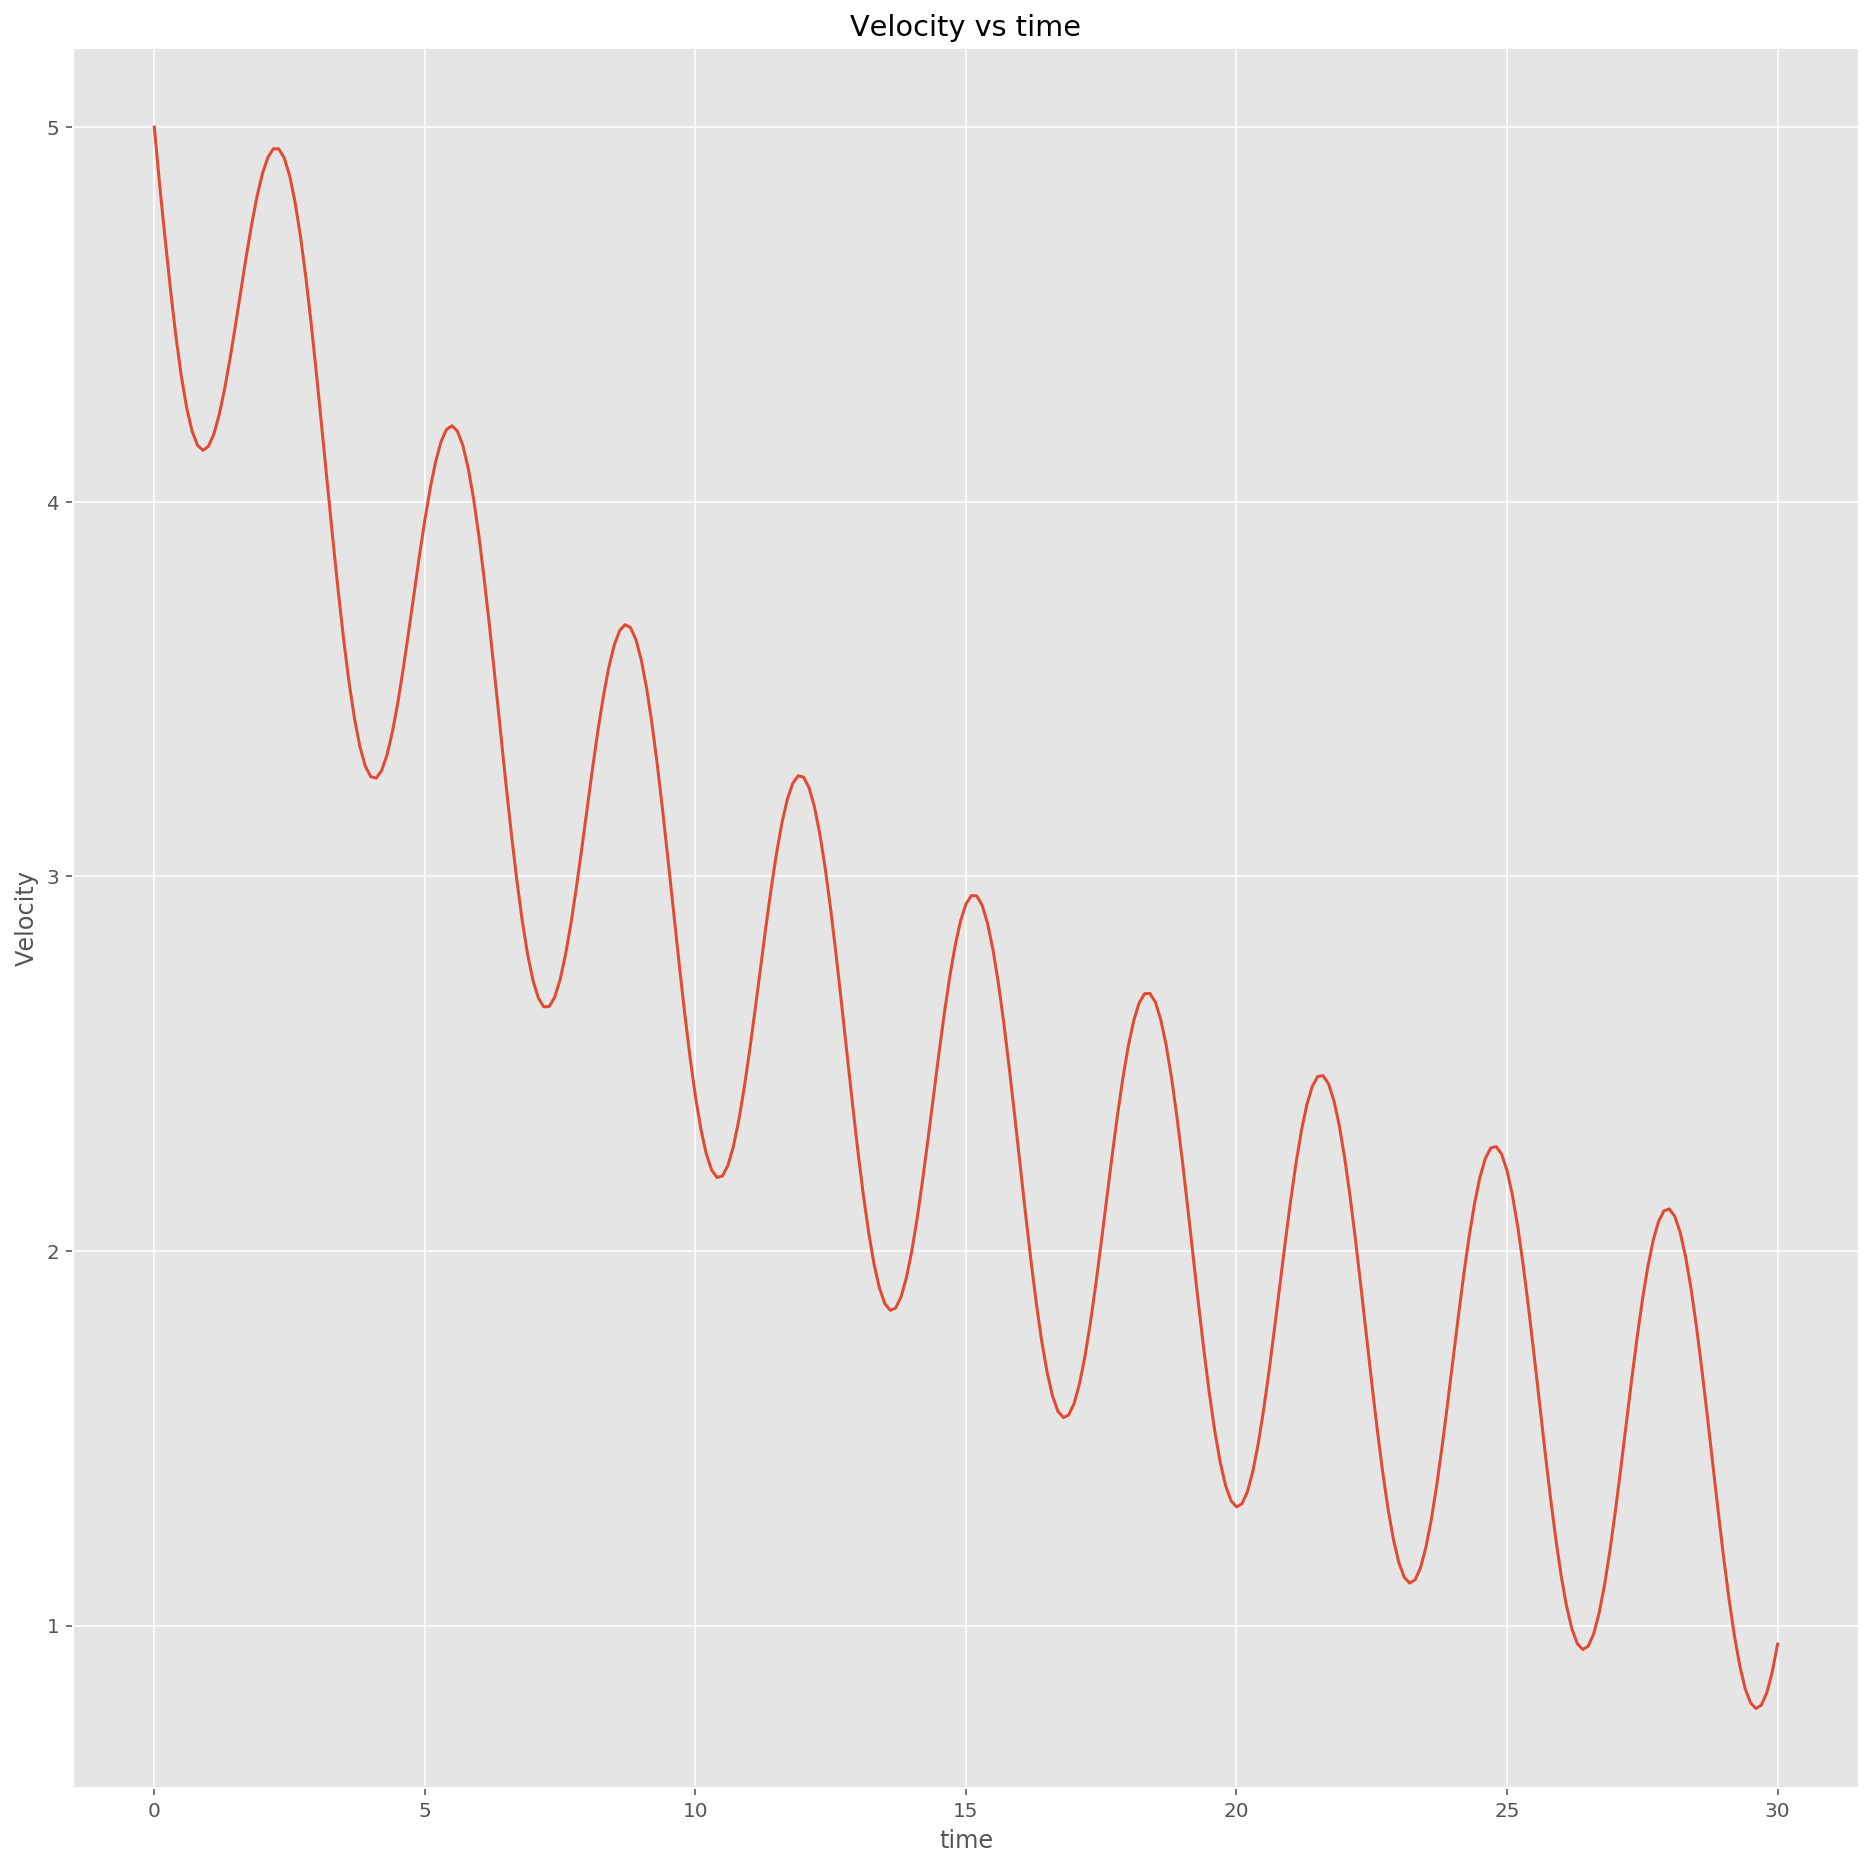

In [36]:
plt.figure()
plt.rcParams['figure.figsize'] = (16,16)
plt.plot(t0, v0 )
plt.xlabel('time')
plt.ylabel('Velocity')
plt.title('Velocity vs time')

Below is the graph of angular velocity vs time over the course of one stroke. There are few different aspects of the rowing stroke that this graph illustrates. First, the initial acceleration appears to be almost linear. This is a direct result of slip, given that the oar is not catching all of the water as the pressure hasn't fully built on the front of the blade it accelerates linearly. Upon fully catching the water this linear behavior stops as the acceleration continues to build in a concave up manner. Upon reaching the peak of the force curve at approximately t =.2 this switches to being concave down and the acceleration starts to flatten out. 

Text(0.5, 1.0, 'Angular Velocity vs time when vi = 5')

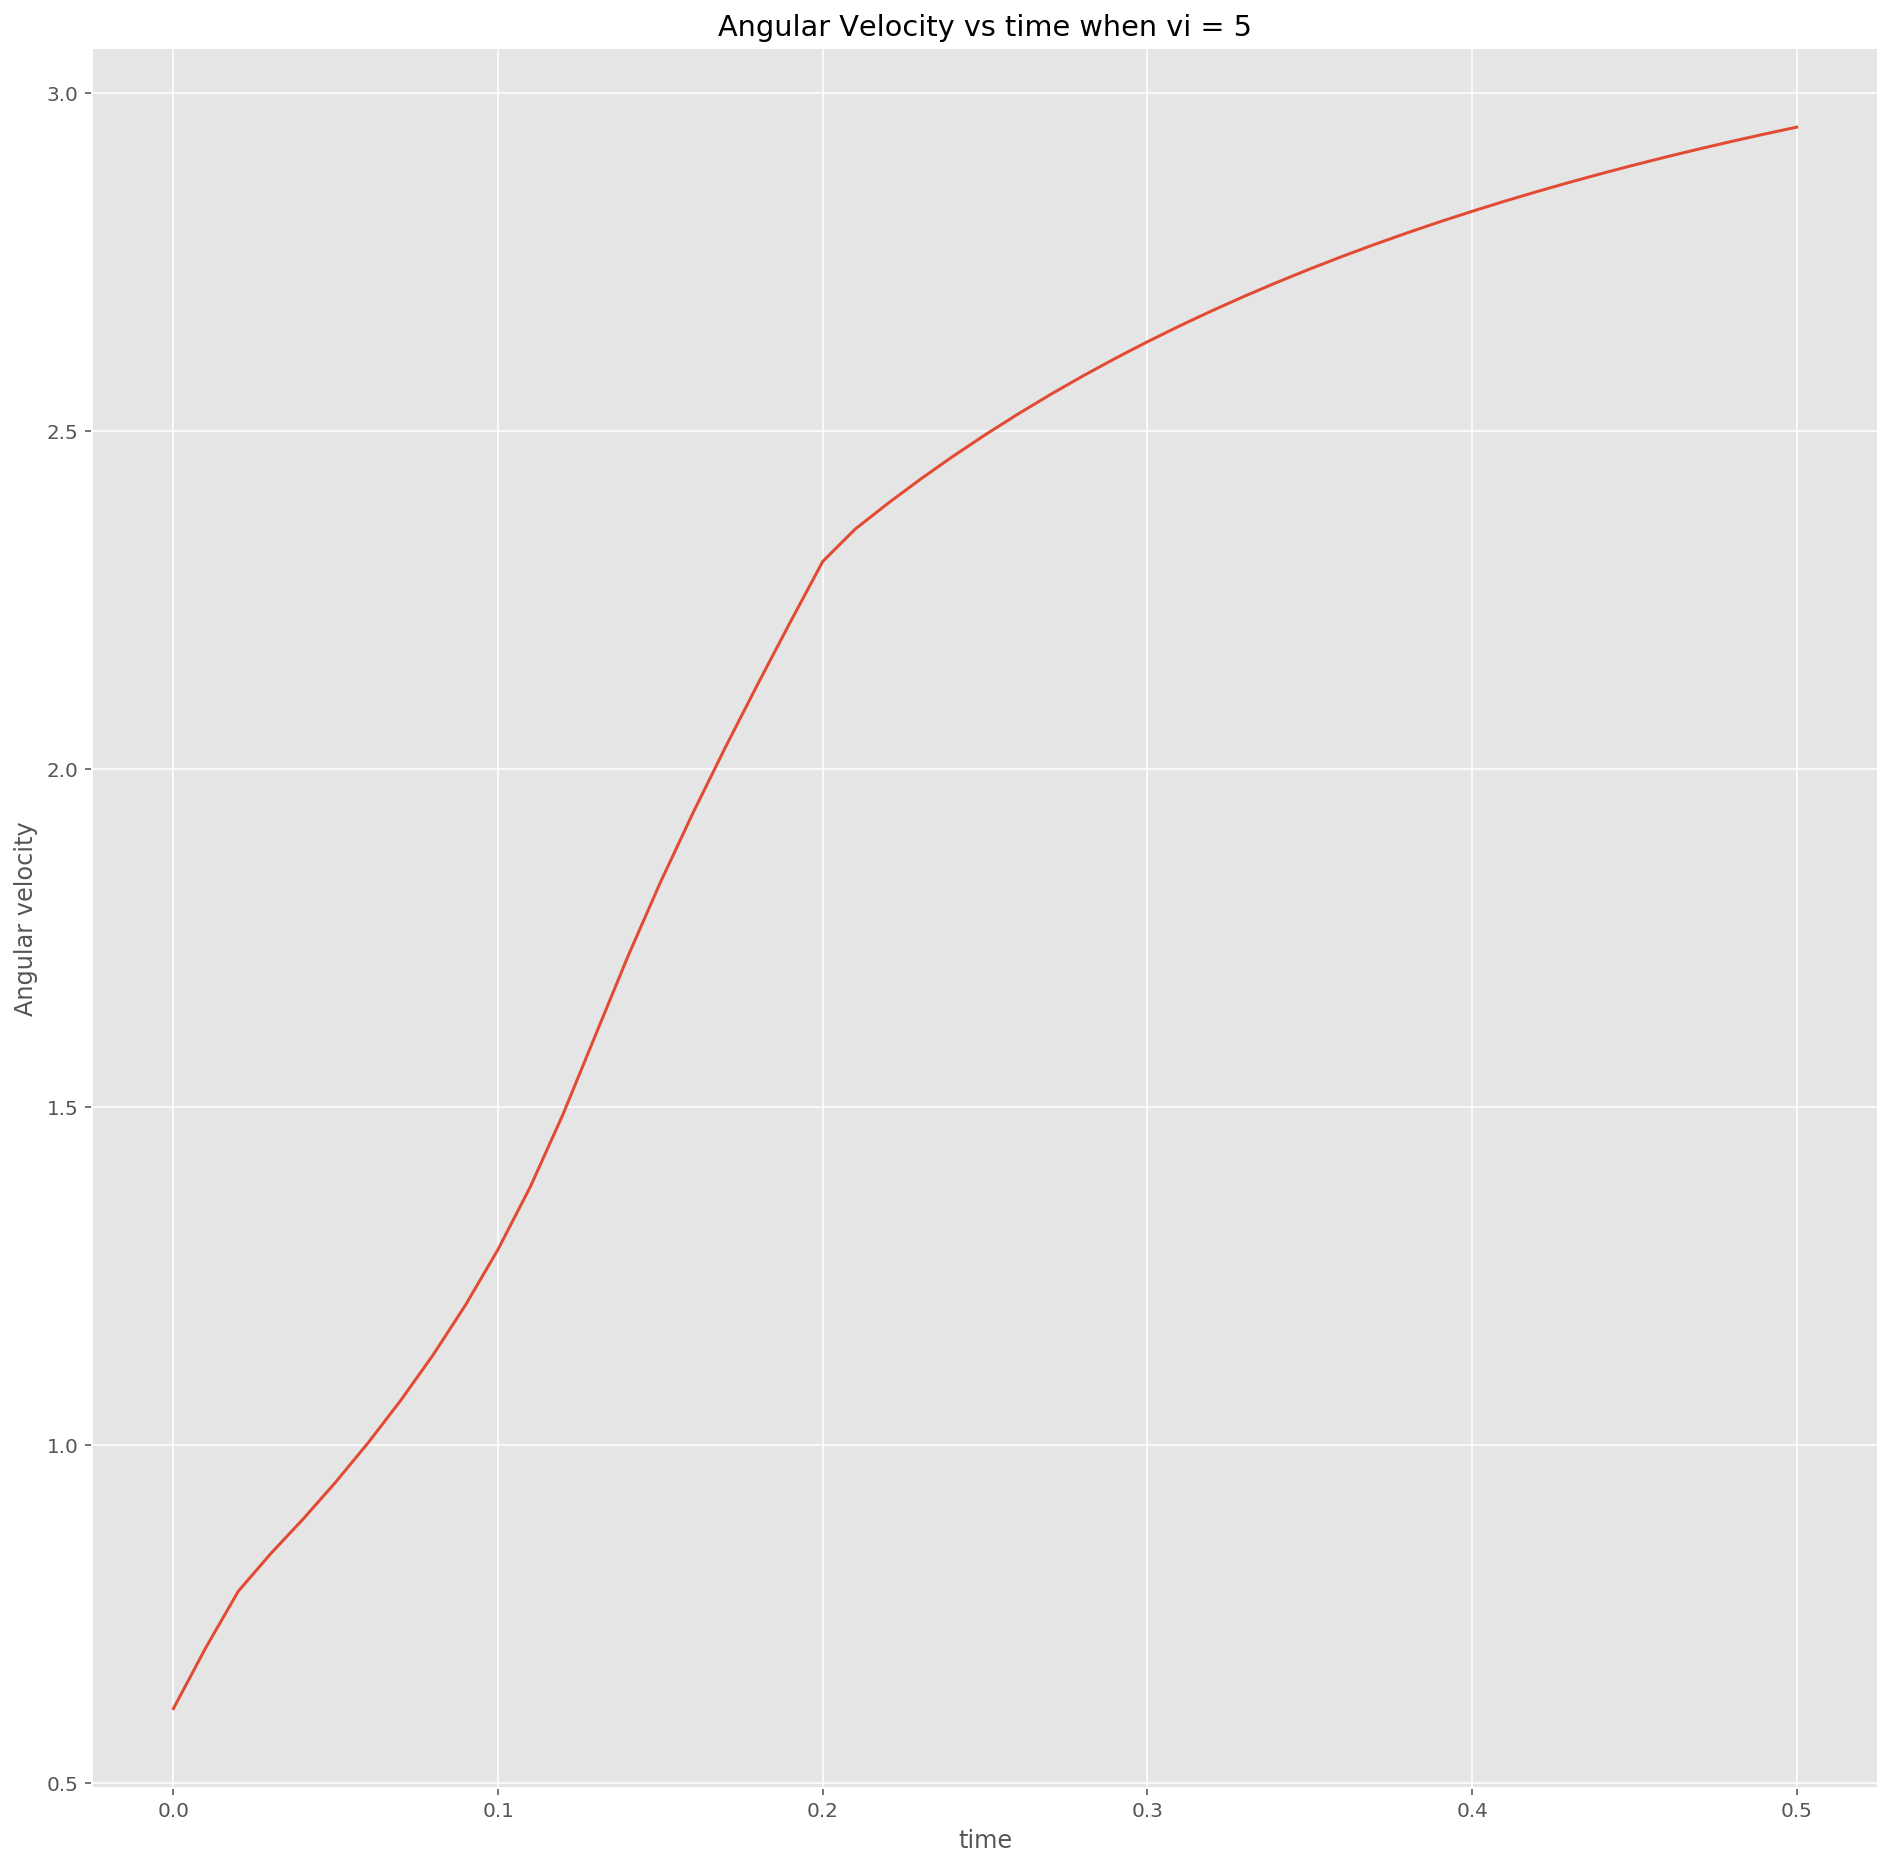

In [9]:
plt.figure()
plt.plot(t0_1, alpha0_1)
plt.xlabel('time')
plt.ylabel('Angular velocity')
plt.title('Angular Velocity vs time when vi = 5')

The graph below illustrates the slip angle / angle of attack for a single stroke. As we can see, the angle of attack remains a constant value before and after the stroke. It is only during the stroke that we see the S curve shape. We have some intution as to why this might make sense. Given that the angle of attack is the angle that the blade is making with the flow of water and the fact that the blade is moving in an arc, we would expect to see this angle changing at the greatest rate in the middle of the stroke and then taper off at the ends. Thus, we are left with an S curve.

Text(0.5, 1.0, 'Slip Angle vs time when vi = 5')

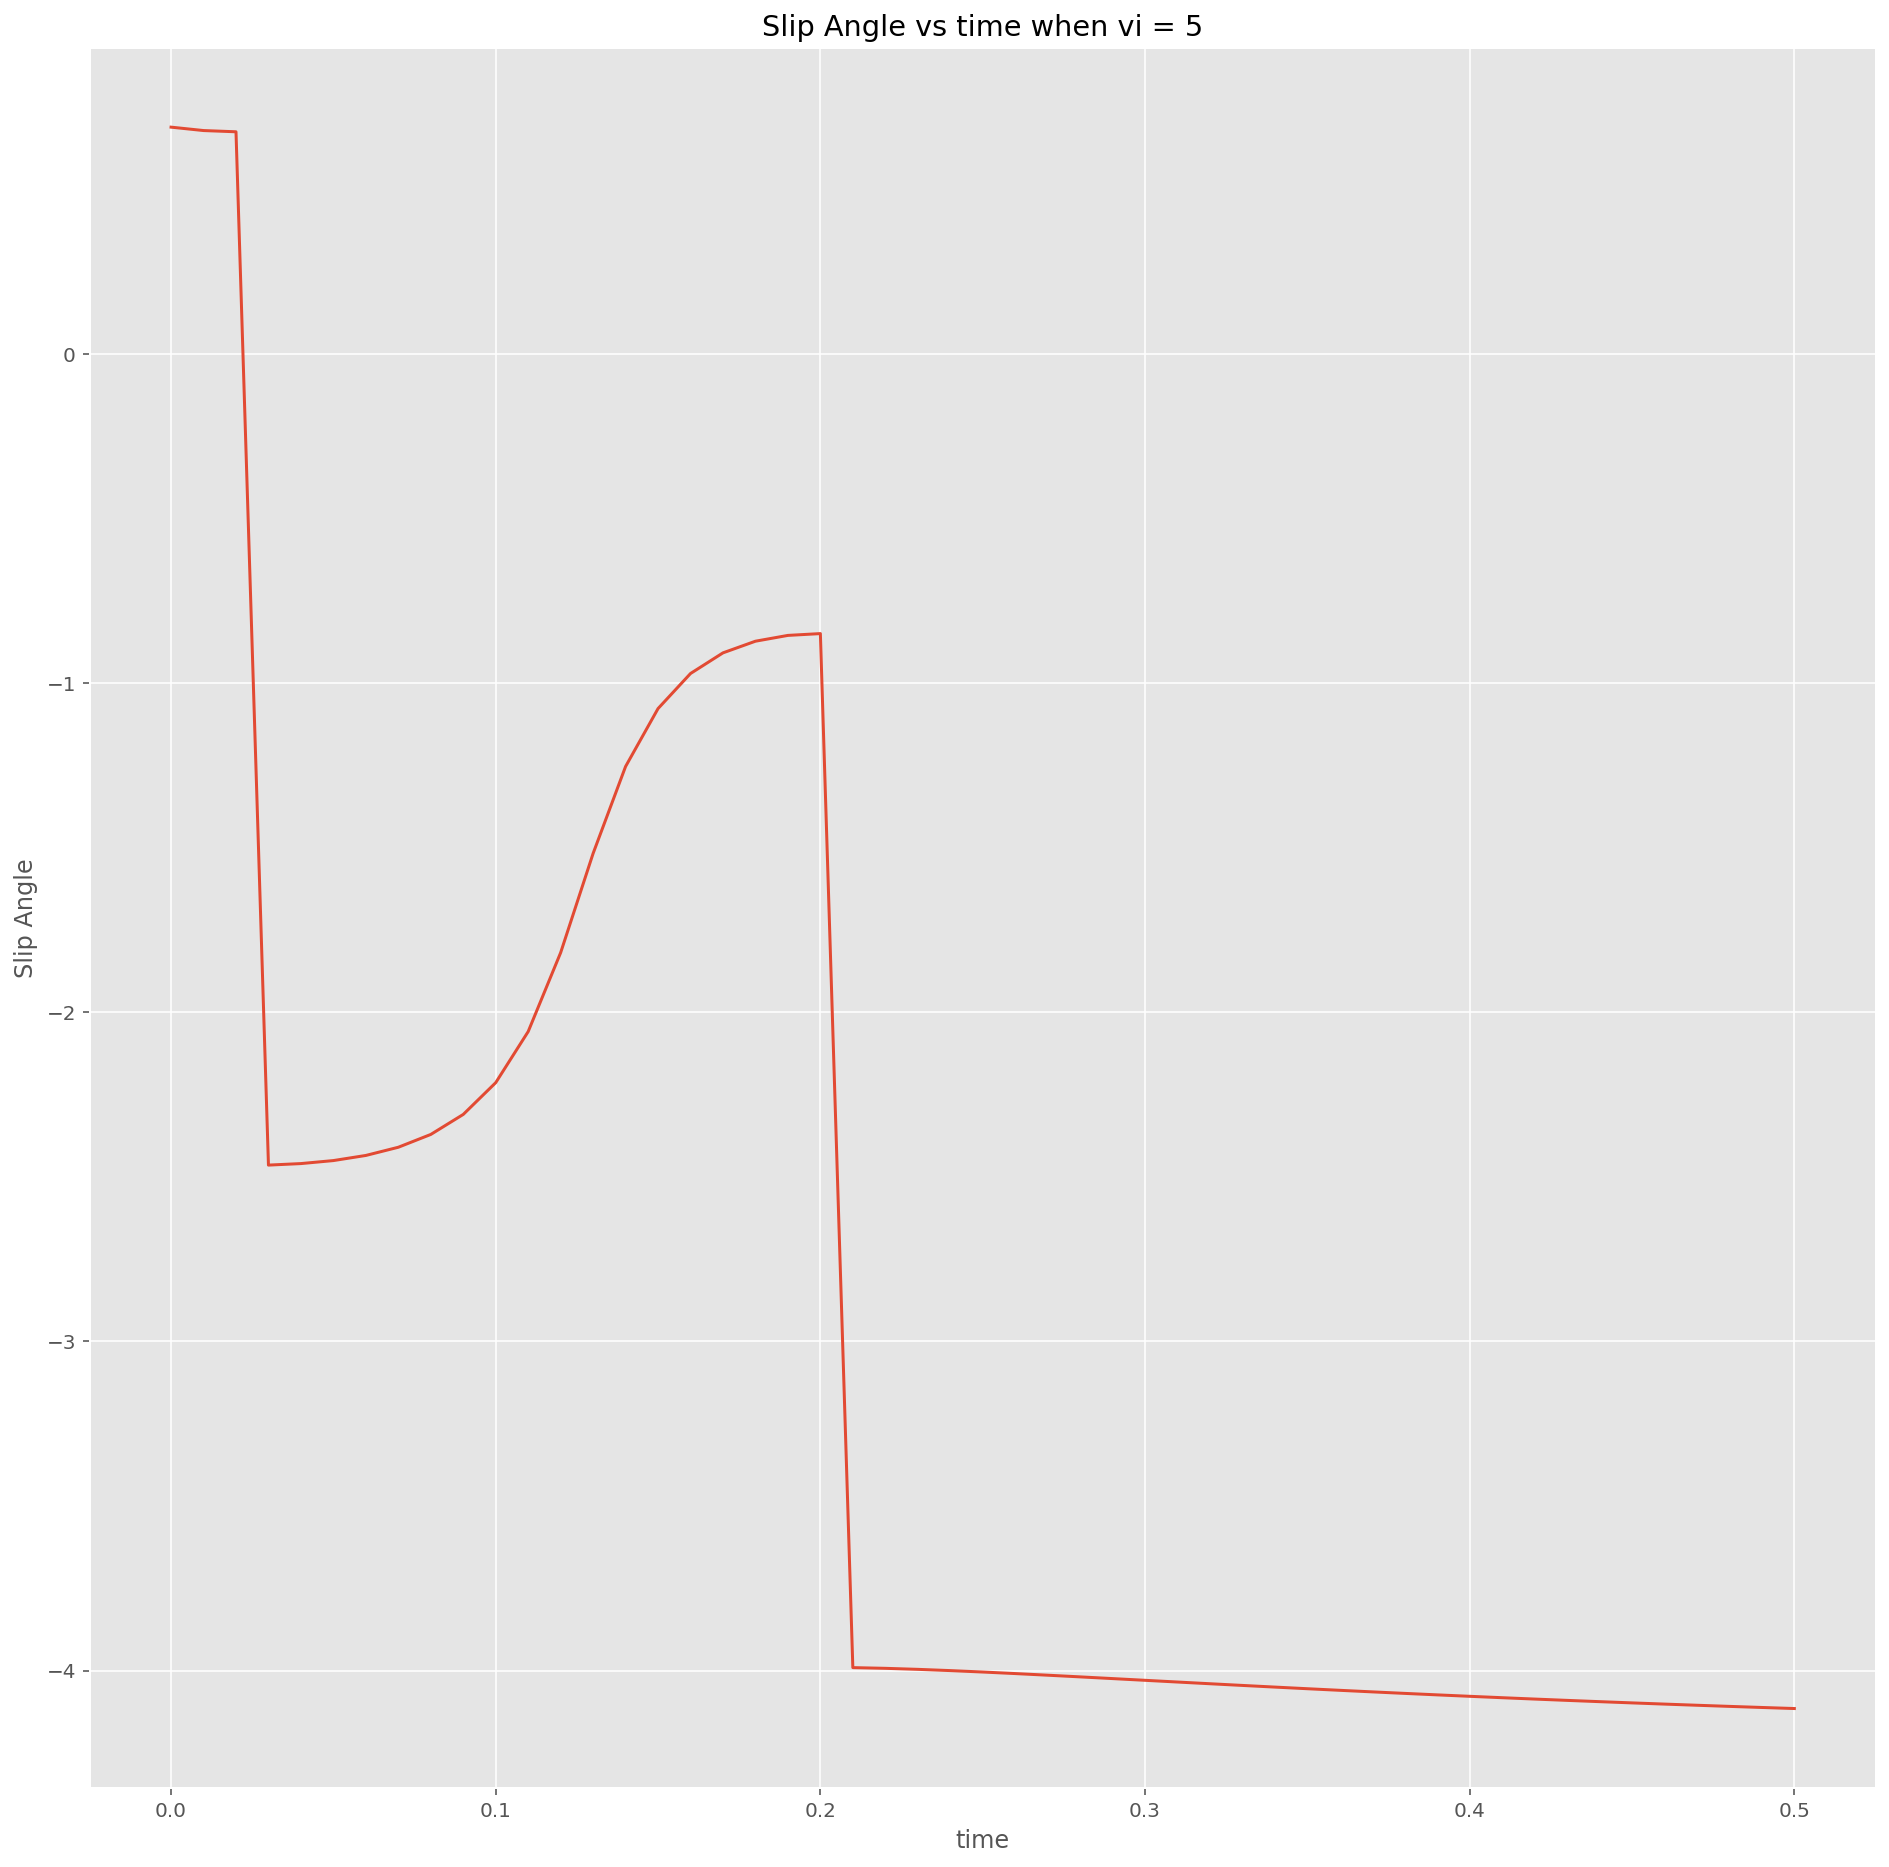

In [10]:
plt.figure()
plt.plot(t0_1, delta(v0_1,alpha0_1))
plt.xlabel('time')
plt.ylabel('Slip Angle')
plt.title('Slip Angle vs time when vi = 5')

The power curve below shows the power as a function of alpha. This curve differs from the one illustrated in the power curves section as alpha is not linear and thus the output of power reflects that and is slightly shifted / altered

Text(0.5, 1.0, 'Power vs time ONE STROKE')

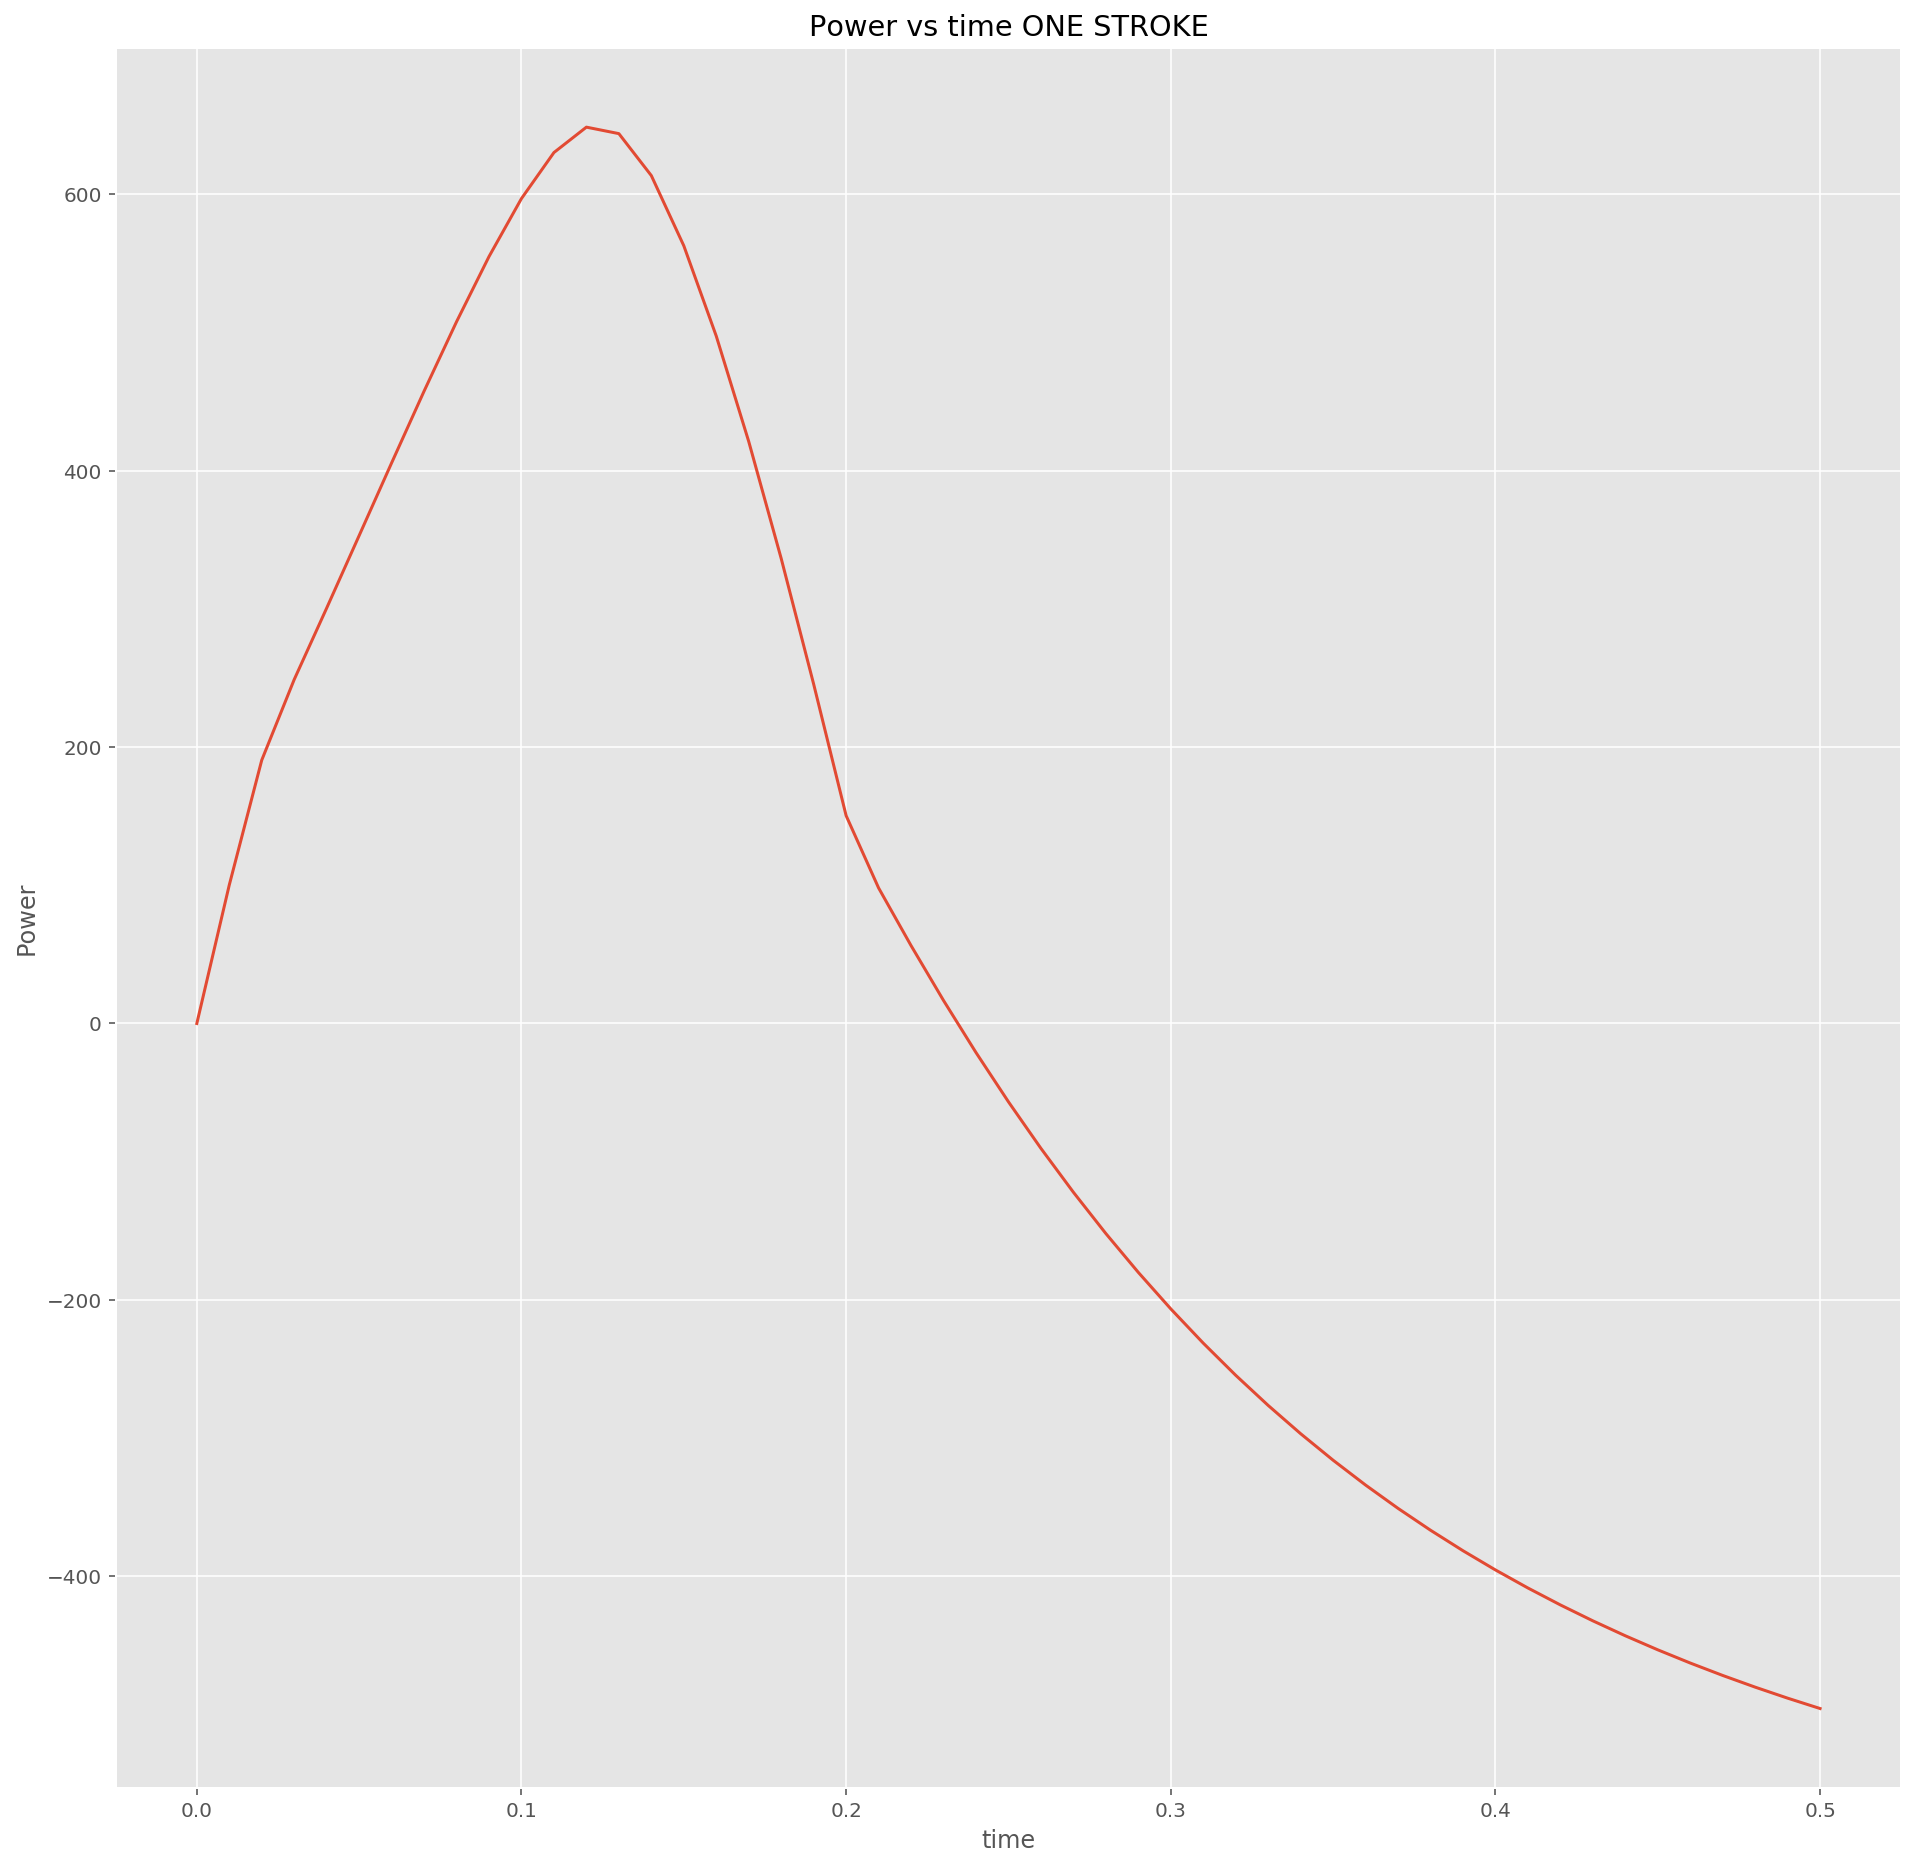

In [11]:
plt.figure()
plt.plot(t0_1, power(alpha0_1))
plt.xlabel('time')
plt.ylabel('Power')
plt.title('Power vs time ONE STROKE')

### Testing Power Profiles

The initial power function that we used has an area under the curve of 758.33. Thus, for all future power functions we will use, the area under the curve will be equal to 758.33. In this following section, I will provide 2 alternative power curves that illustrate various properties of power curves and will evaluate their impact on boat movement. First we will look at our original force curve which is simply a constrained sin function. 

In [12]:
BURBLINSPACE = np.linspace(.6109, 2.443,100)

Text(0.5, 1.0, 'Power vs time ONE STROKE')

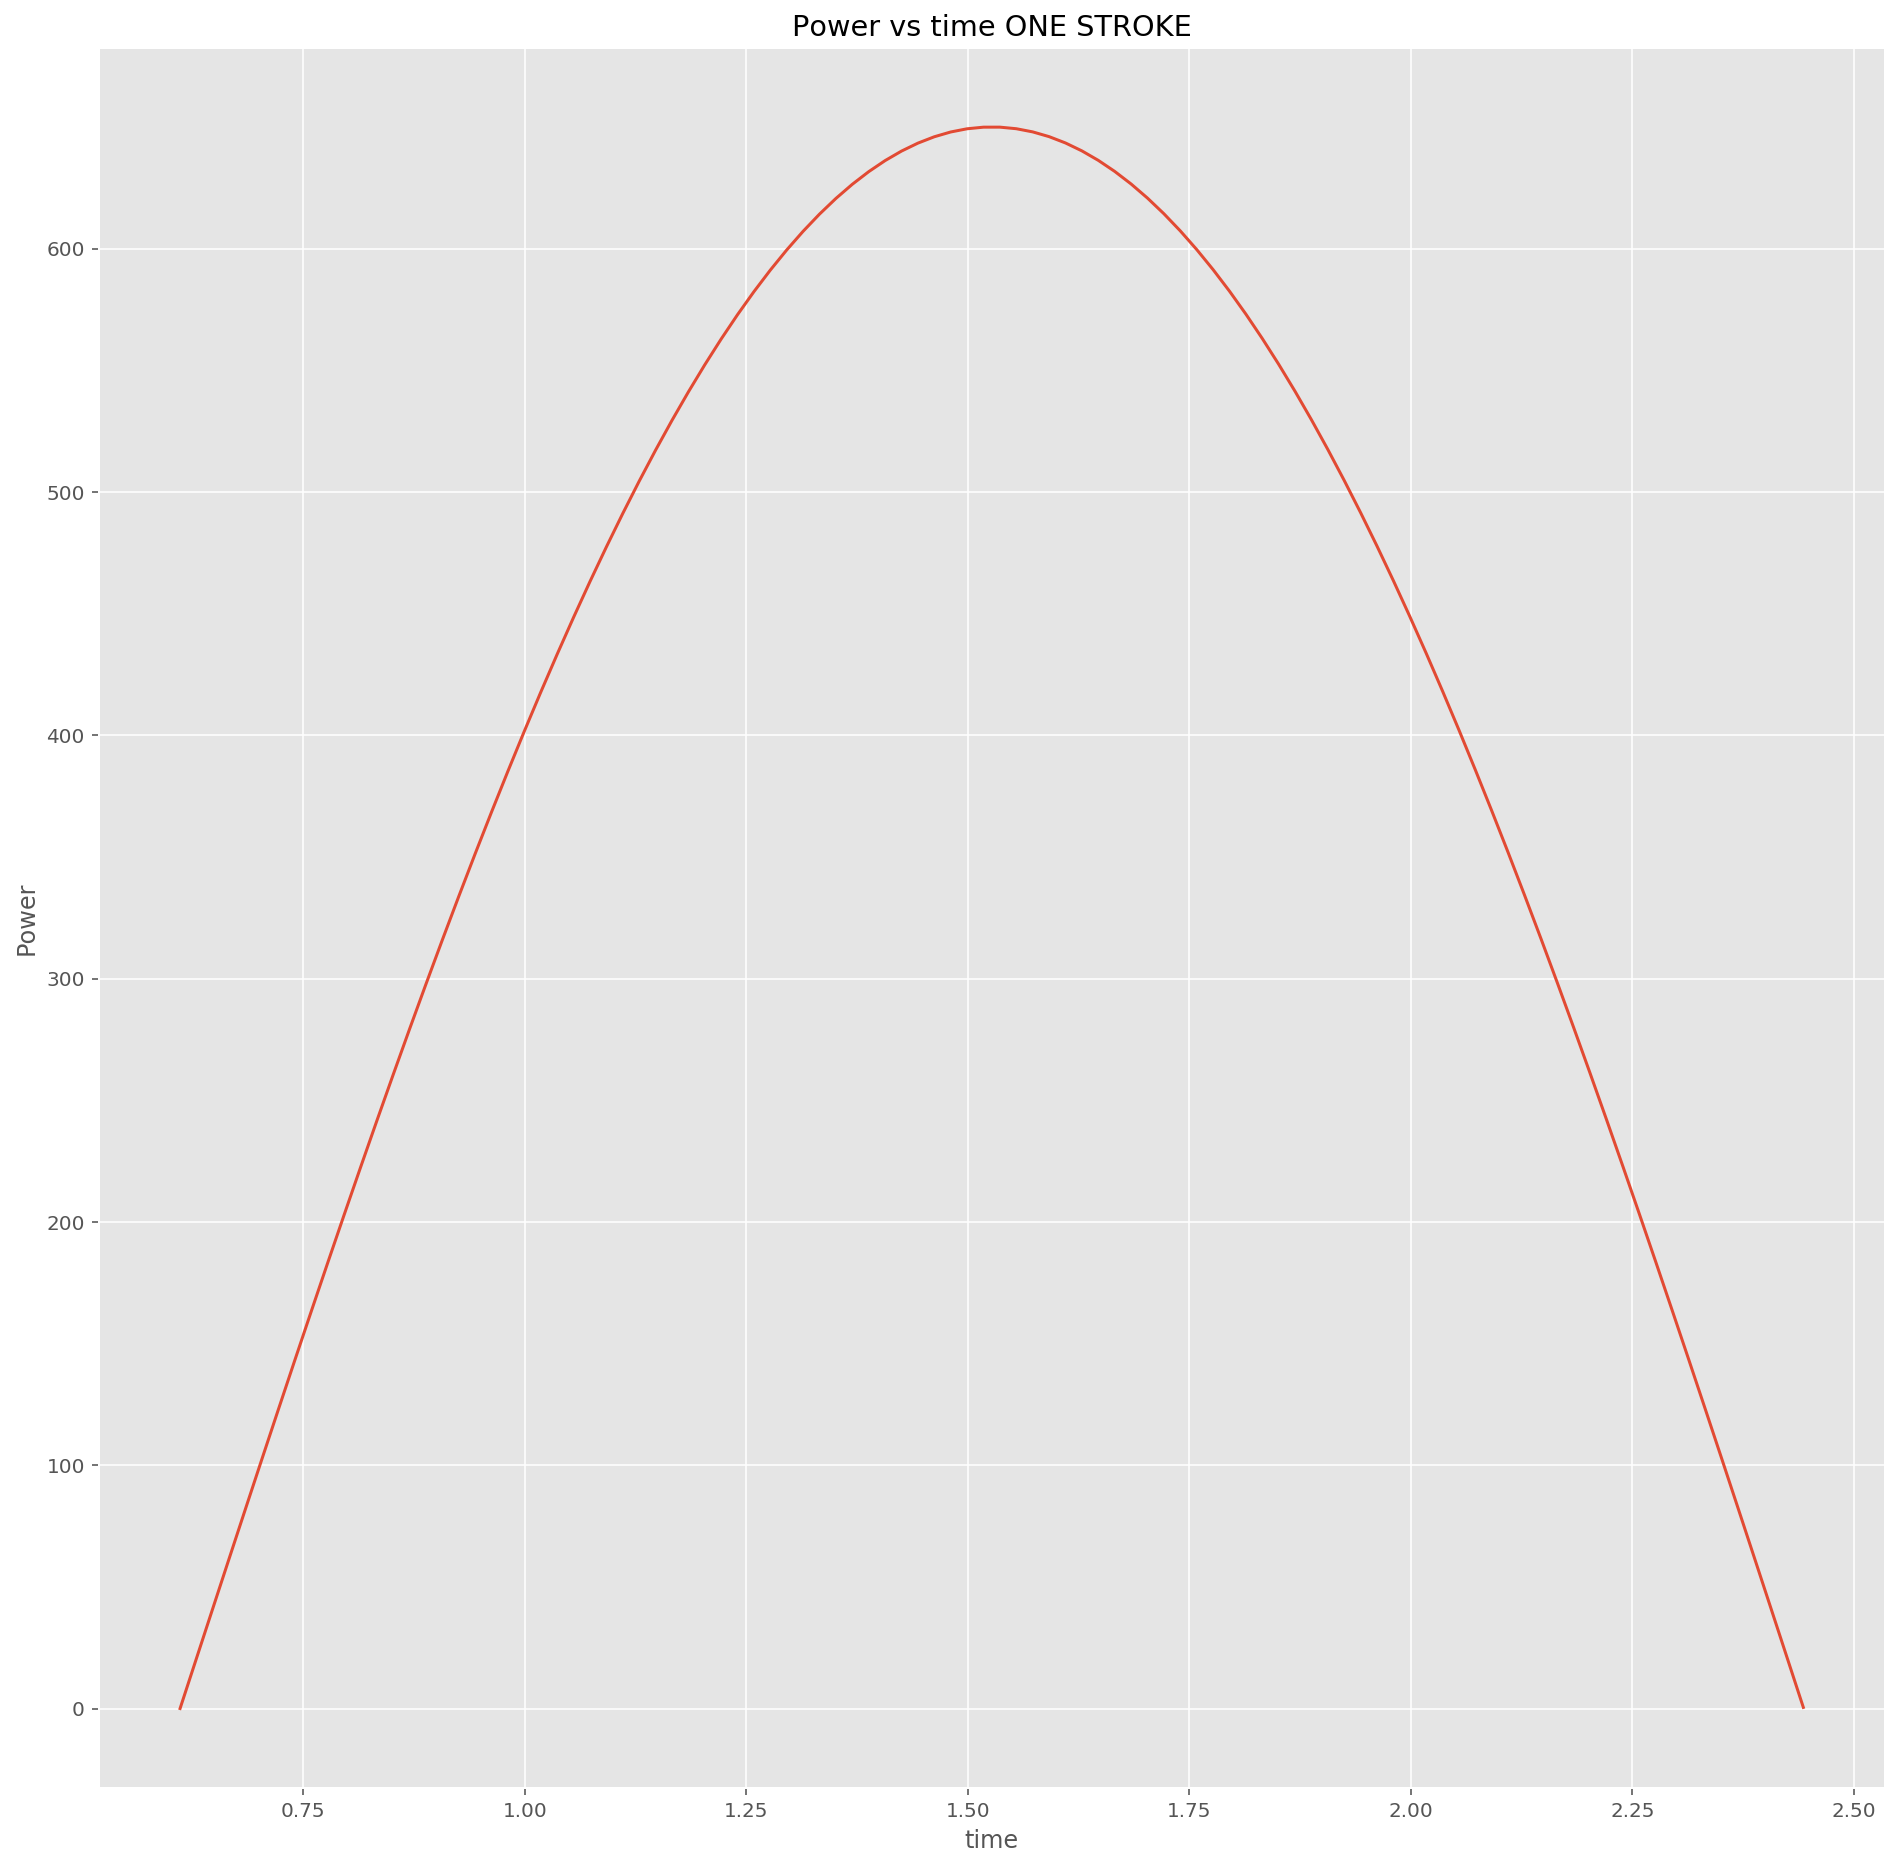

In [13]:
plt.figure()
plt.plot(BURBLINSPACE,(power(BURBLINSPACE)))
plt.xlabel('time')
plt.ylabel('Power')
plt.title('Power vs time ONE STROKE')

This is the basic power curve that we will use as a basis with which to compare the efficacy of our other power curves to. Certainly, there is nothing special about this power curve. It fits the generally accepted form of a good power curve; it is  one fluid curve that tapers off at the end of the stroke. It is not necesarily optimized, however, it serves our purposes quite nicely. 

### Rectangular Curve
Theoretically, the rectangular curve is the most mechanically efficient curve. Such a curve implies a constant force output and inherently the lowest maximal force  for the same overall output. From a biomechanics perspective this is impossible, however, it is worth illustrating. Analogs to this would be a gumdrop shaped curve or other curves that have steep influxes and effluxes. This was one of the easier force curves to create as it is simply a line, thus in order to create it I simply had to find the correct height  

In [14]:
def RECpower(alpha):
    return 413.80*np.ones(len(alpha))

Text(0.5, 1.0, 'Power vs time ONE STROKE')

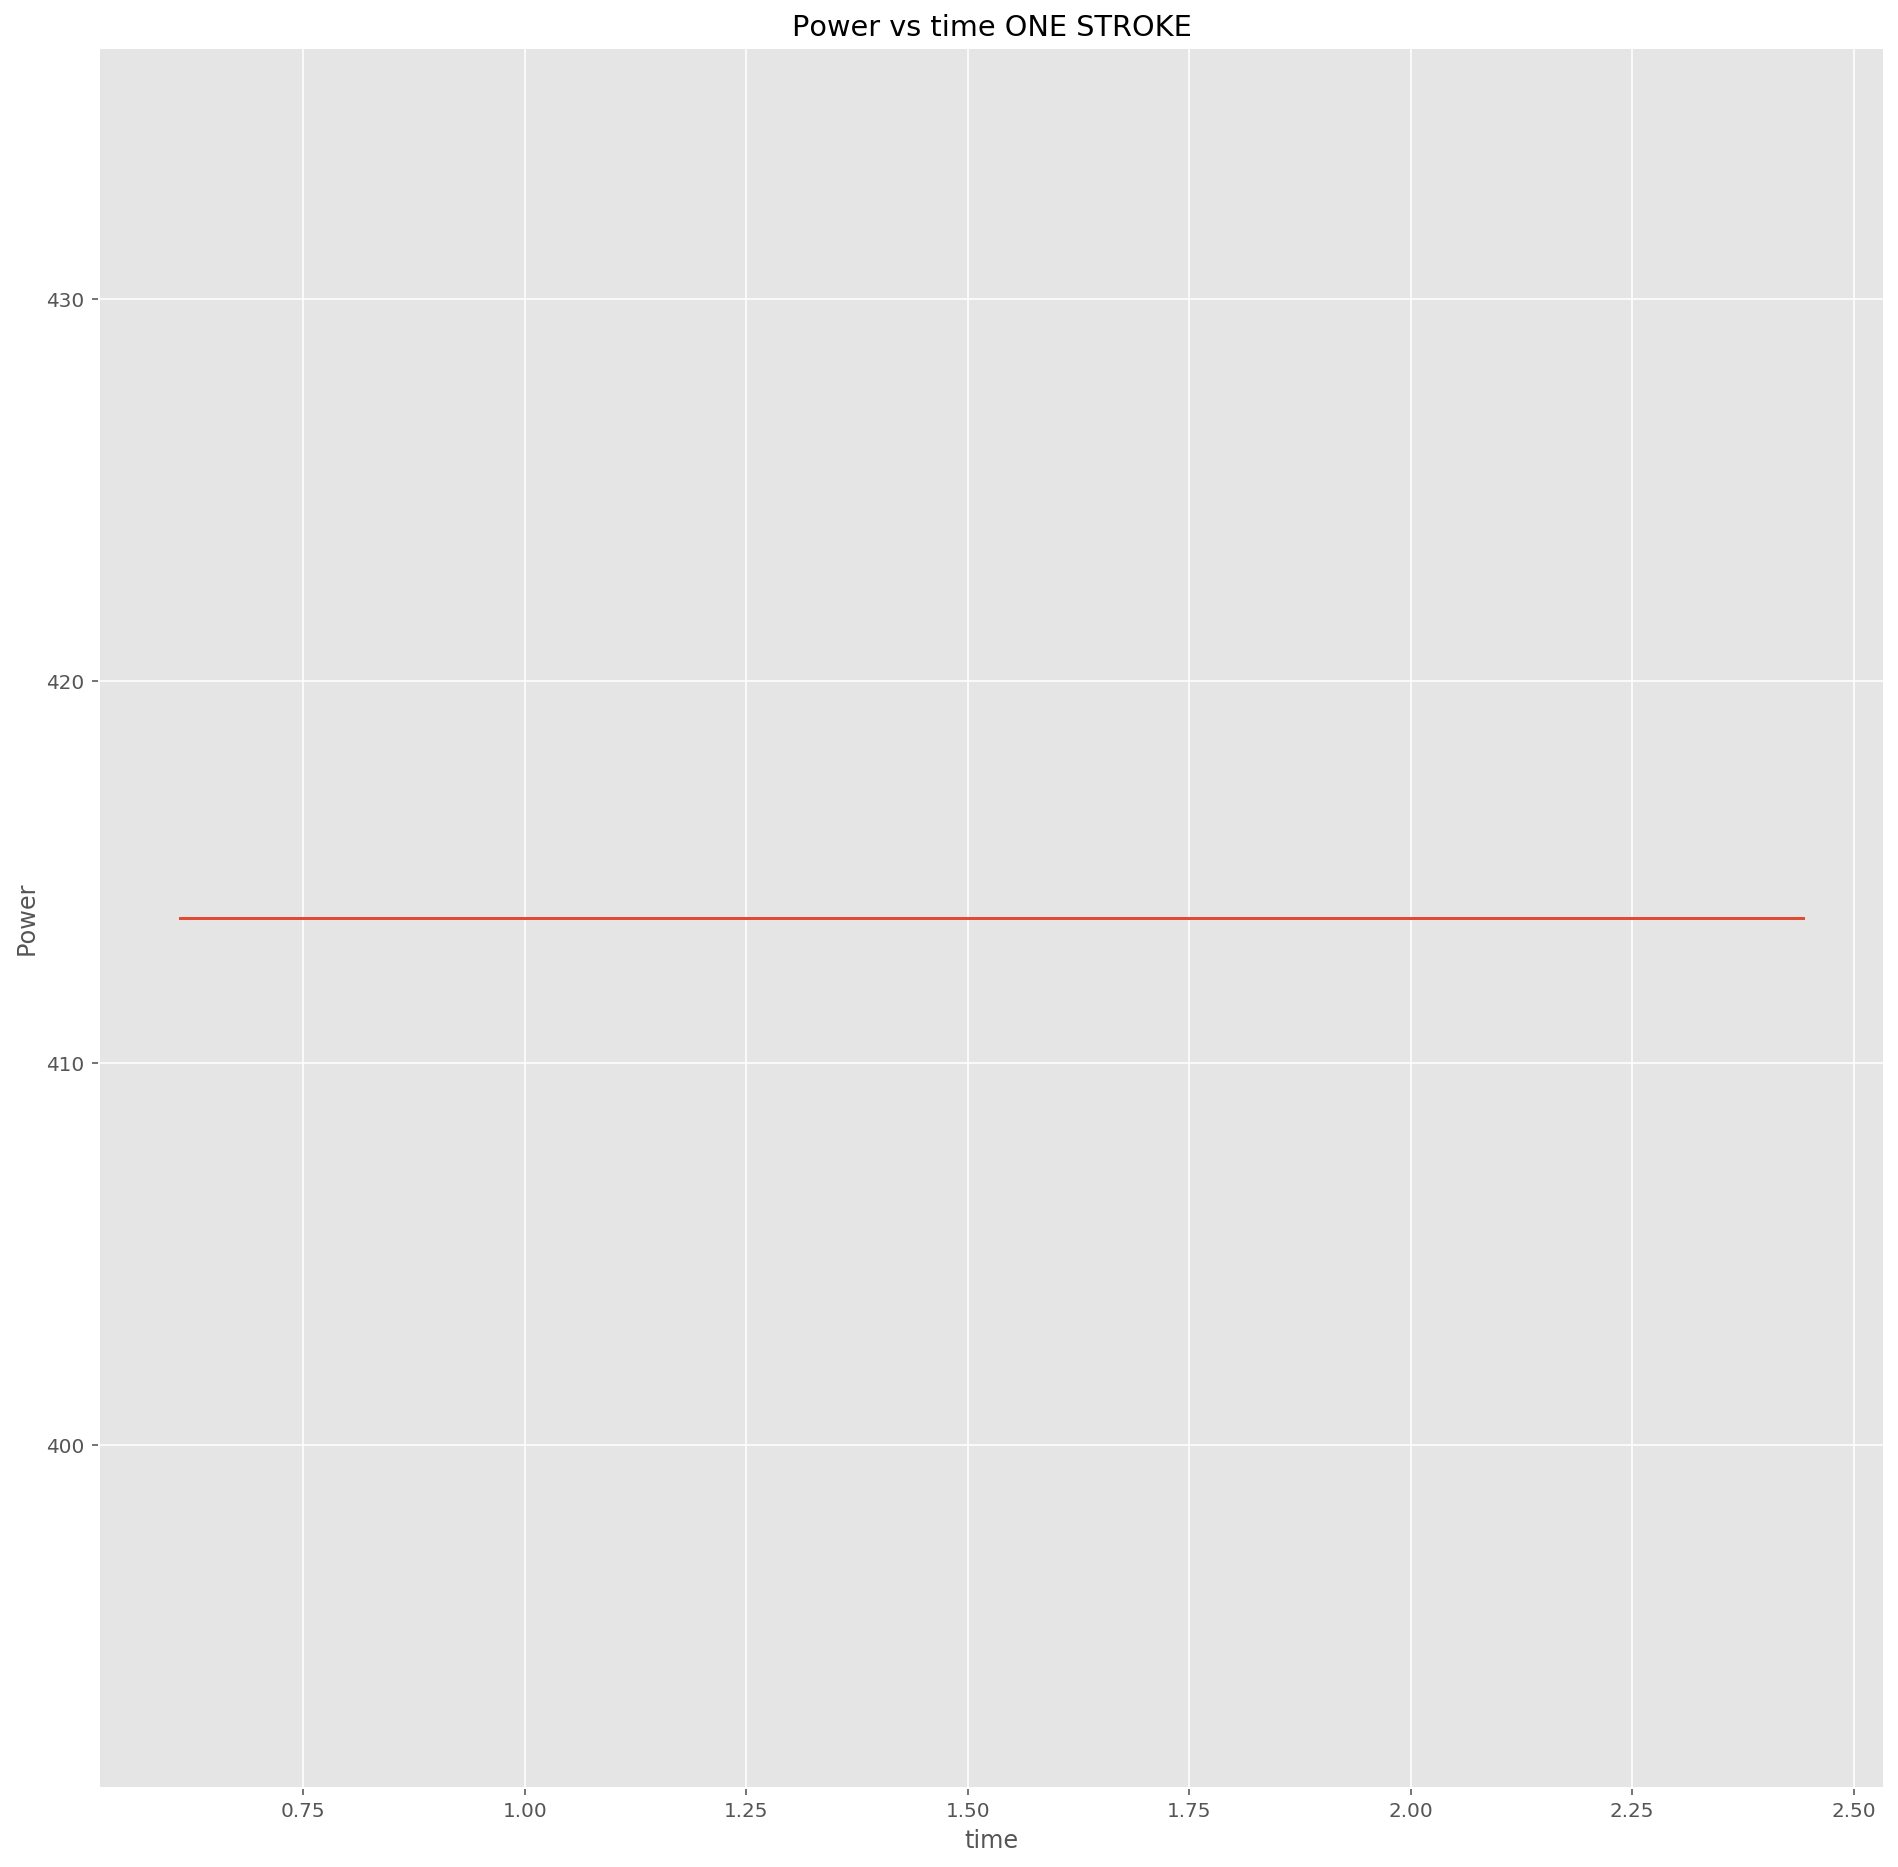

In [20]:
plt.figure()
plt.plot(BURBLINSPACE,(RECpower(BURBLINSPACE)))
plt.xlabel('time')
plt.ylabel('Power')
plt.title('Power vs time ONE STROKE')

### The BURB

This last power curve is not in any way modeled after the optimal rowing stroke, instead it is modelled after one of my teammates. It stands contrary to general wisdom regarding the smoothness of a power curve. The presence of two separate humps is indicative of having two separate drive phases. Typically, when taught to row the two phases finish simultaneously and the peak power occurs at the transition in which both your legs and back are fully engaged.

In [25]:
def BURBpower3(alpha):
        if (np.any((np.where((alpha >= (alphainitial)) & (alpha <= (alphafinal)))))):
            return 240.82*(-1*(4.028*(alpha - 1.05*1.4662)**4 -(alpha - 1.1*1.4662)**2)+2)
        else:
            return 0

In [26]:
def EOMBURBROW(t,f,waterdensity, Abl, cnst, mr, mb, oarlength, bladelength, Pmax, alphainitial, alphafinal, inboardlength, gamma):
    dVboatdt = ((8 * Fhx(f[0], f[1])) - (mr*roweracceleration(t) + R(f[0], f[1])))/(mr + mb)
    dalphadt = Vblade(f[0],f[1])*np.sin(6*np.pi/180 + delta(f[0], f[1]) - gamma) + (f[0] * np.sin(f[1] + gamma))
    denergydt = (8 * BURBpower3(f[1])* dalphadt * inboardlength * ((1/oarlength)*(Vblade(f[0],f[1])*np.sin((6*np.pi/180 + delta(f[0], f[1]) - gamma)) + (f[0] * np.sin(f[1] + gamma))) - (mr * roweracceleration(t) * f[0])) - (R(f[0], f[1]) * f[0] + (8 * Vblade(f[0],f[1]) * D(f[0],f[1]))))
    return np.array([dVboatdt, dalphadt,denergydt])

In [27]:
rk4(f, 0, .001, EOMBURBROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)

array([4.99863432e+00, 6.19891330e-01, 1.01235087e+04])

In [28]:
v0BURB, alpha0BURB, energy0BURB, t0BURB = rk_driver(f, 0, 30, .1, EOMBURBROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)
v0_1BURB, alpha0_1BURB, energy0_1BURB, t0_1BURB = rk_driver(f, 0, .24, .01, EOMBURBROW, 1000, 1100e-04, .5*1000*1100e-04, mr, mb, 2.10, .37, 650, 35*np.pi/180, 140*np.pi/180, 1, gamma)

Text(0.5, 1.0, 'Power vs time ONE STROKE')

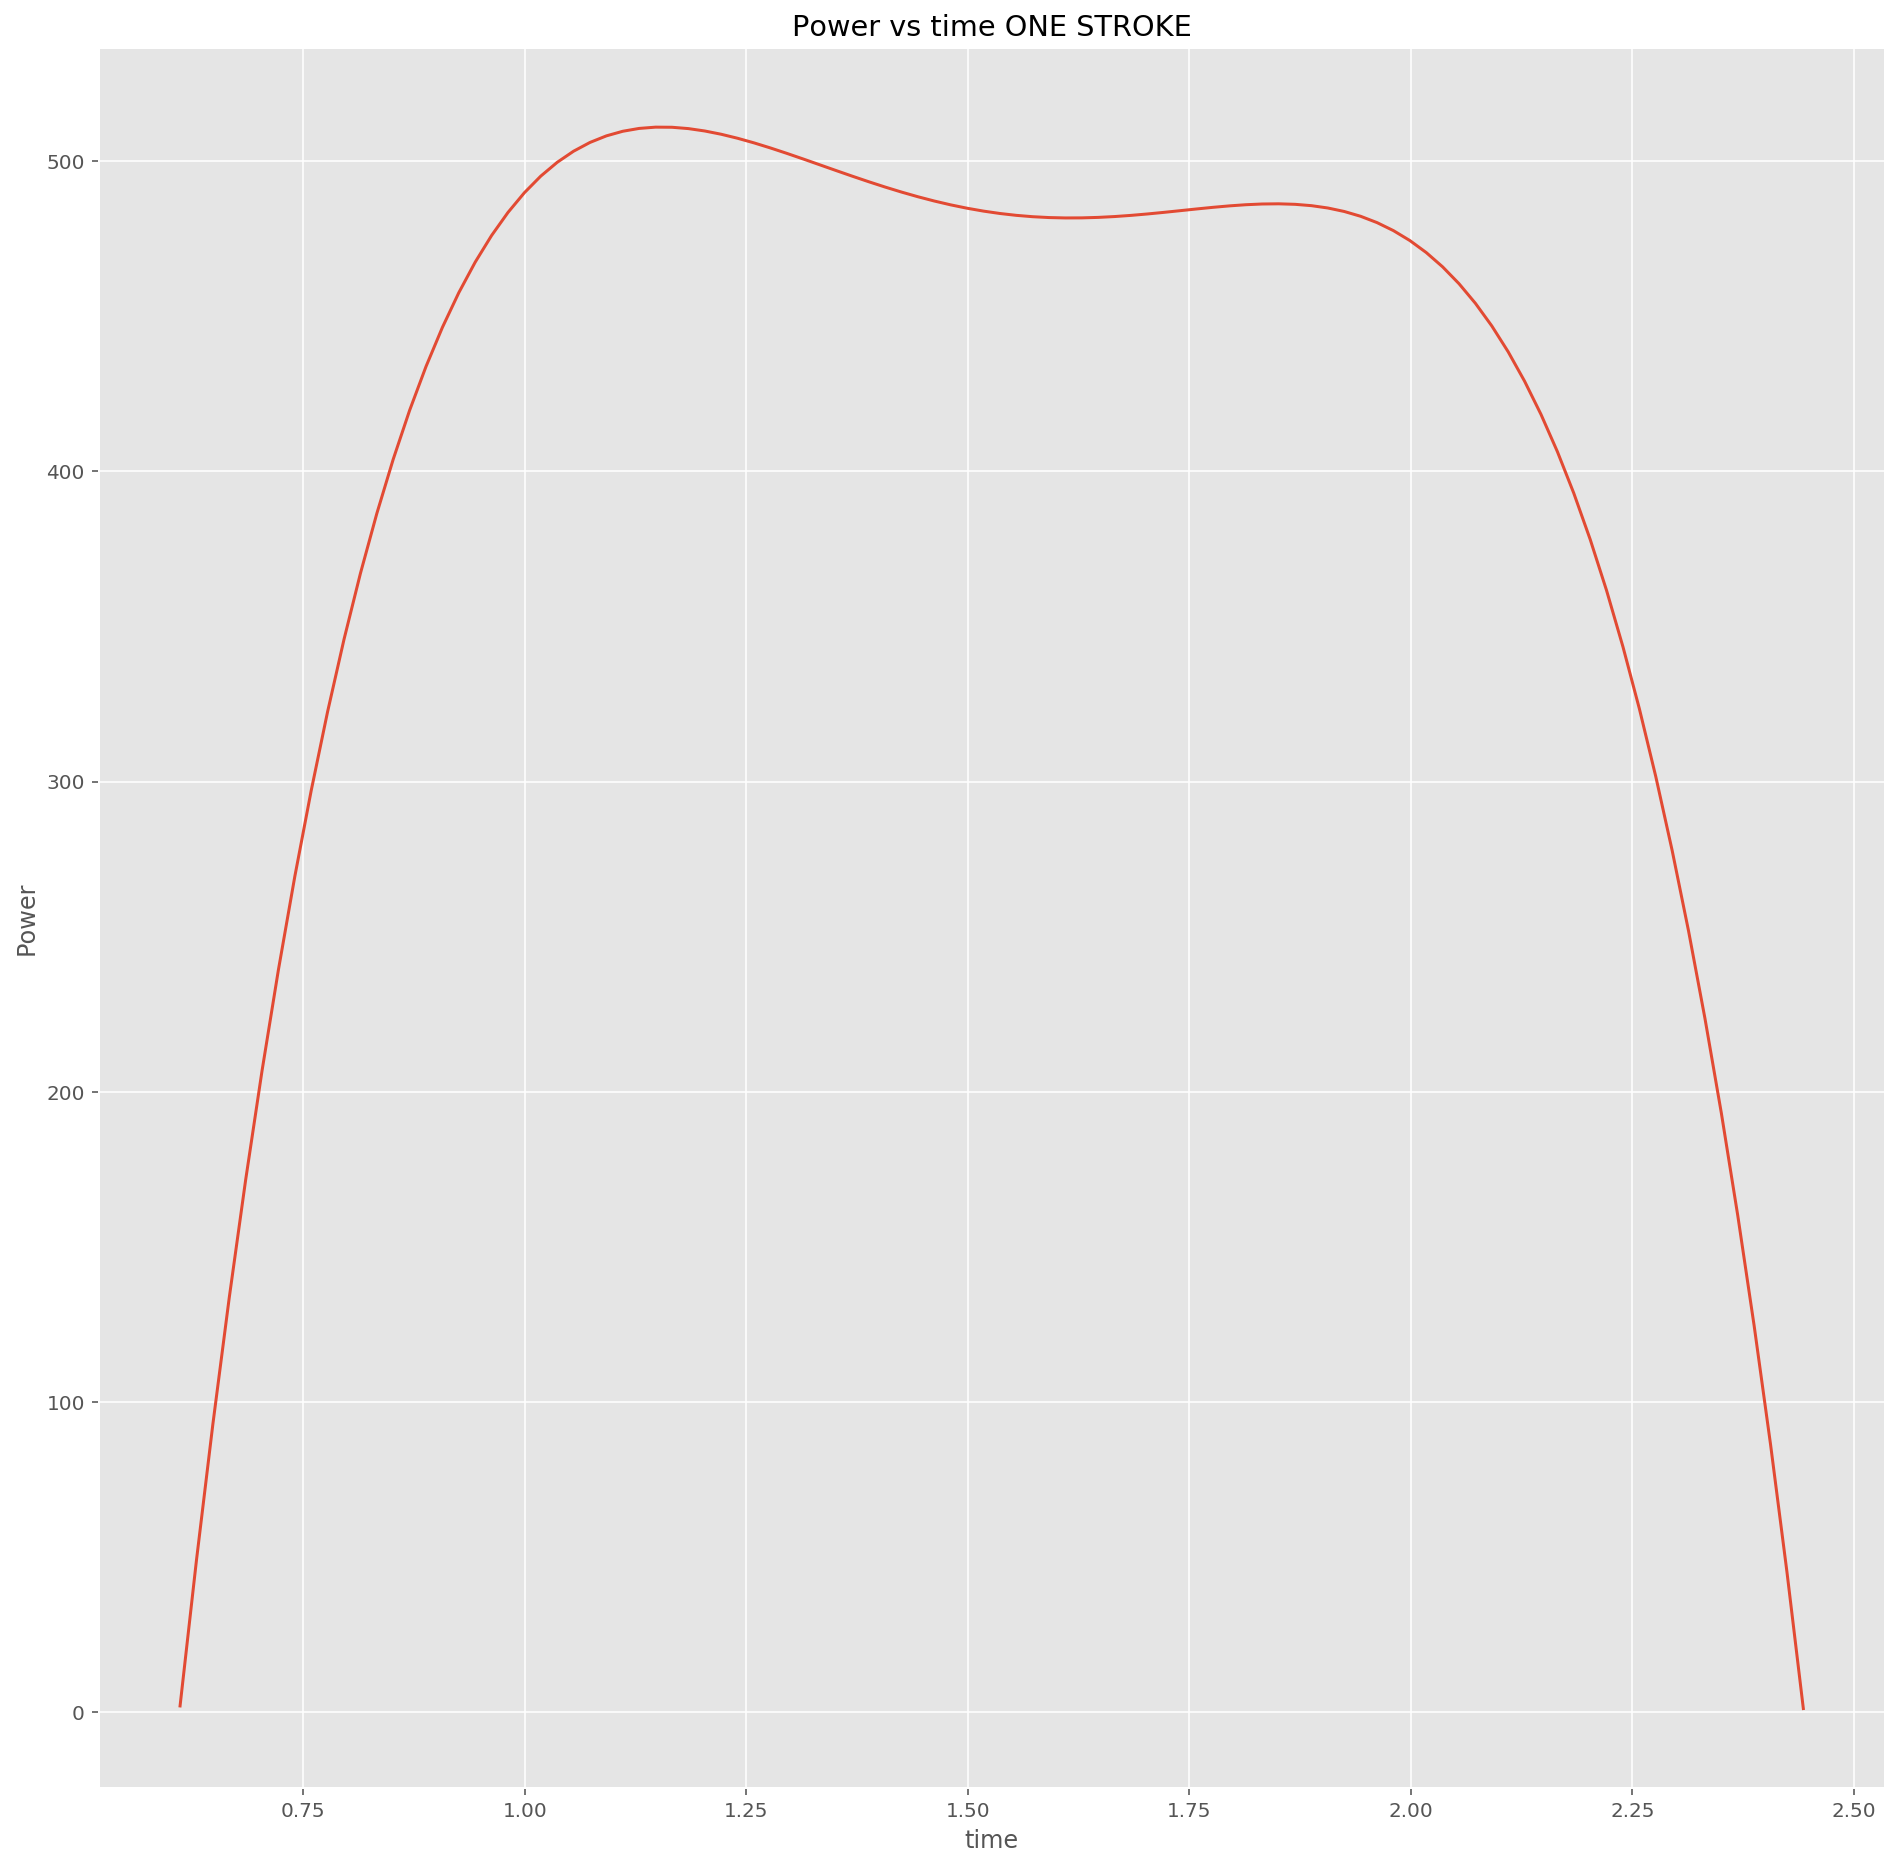

In [29]:
plt.figure()
plt.plot(BURBLINSPACE,(BURBpower3(BURBLINSPACE)))
plt.xlabel('time')
plt.ylabel('Power')
plt.title('Power vs time ONE STROKE')

Text(0.5, 1.0, 'ACTUAL Power as a function of Alpha')

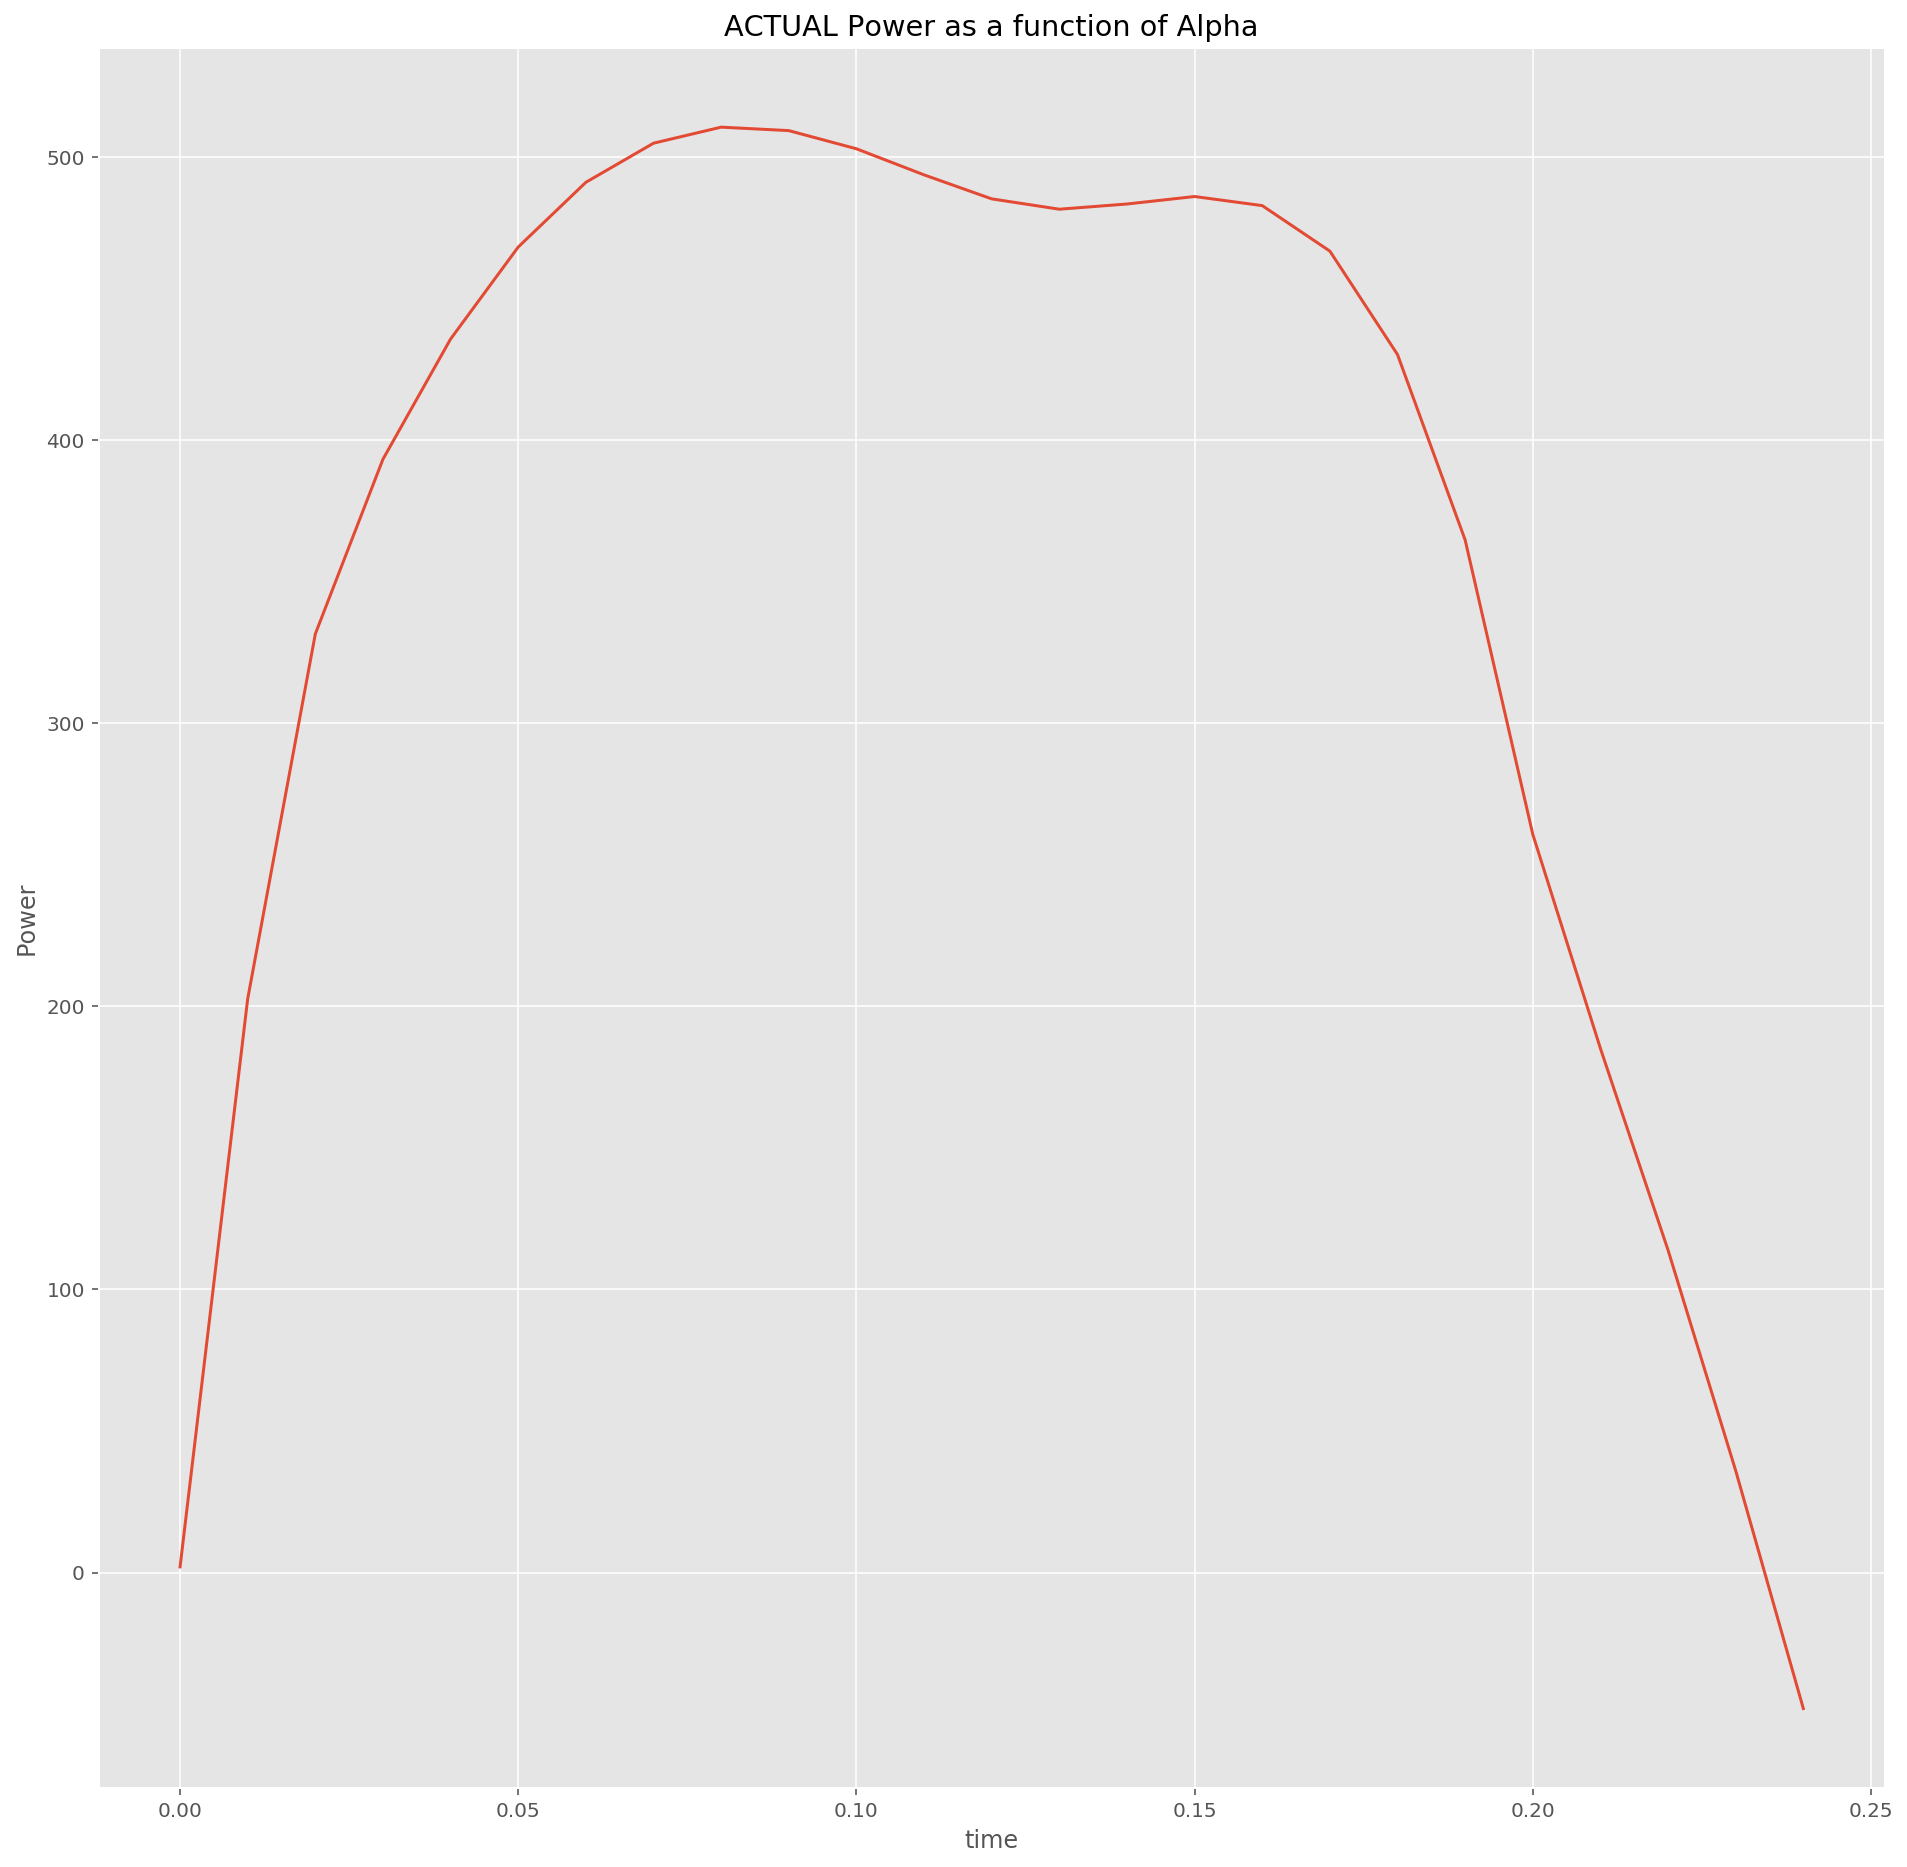

In [30]:
plt.figure()
plt.plot(t0_1BURB, BURBpower3(alpha0_1BURB))
plt.xlabel('time')
plt.ylabel('Power')
plt.title('ACTUAL Power as a function of Alpha')

Text(0.5, 1.0, 'Slip Angle vs time when vi = 5')

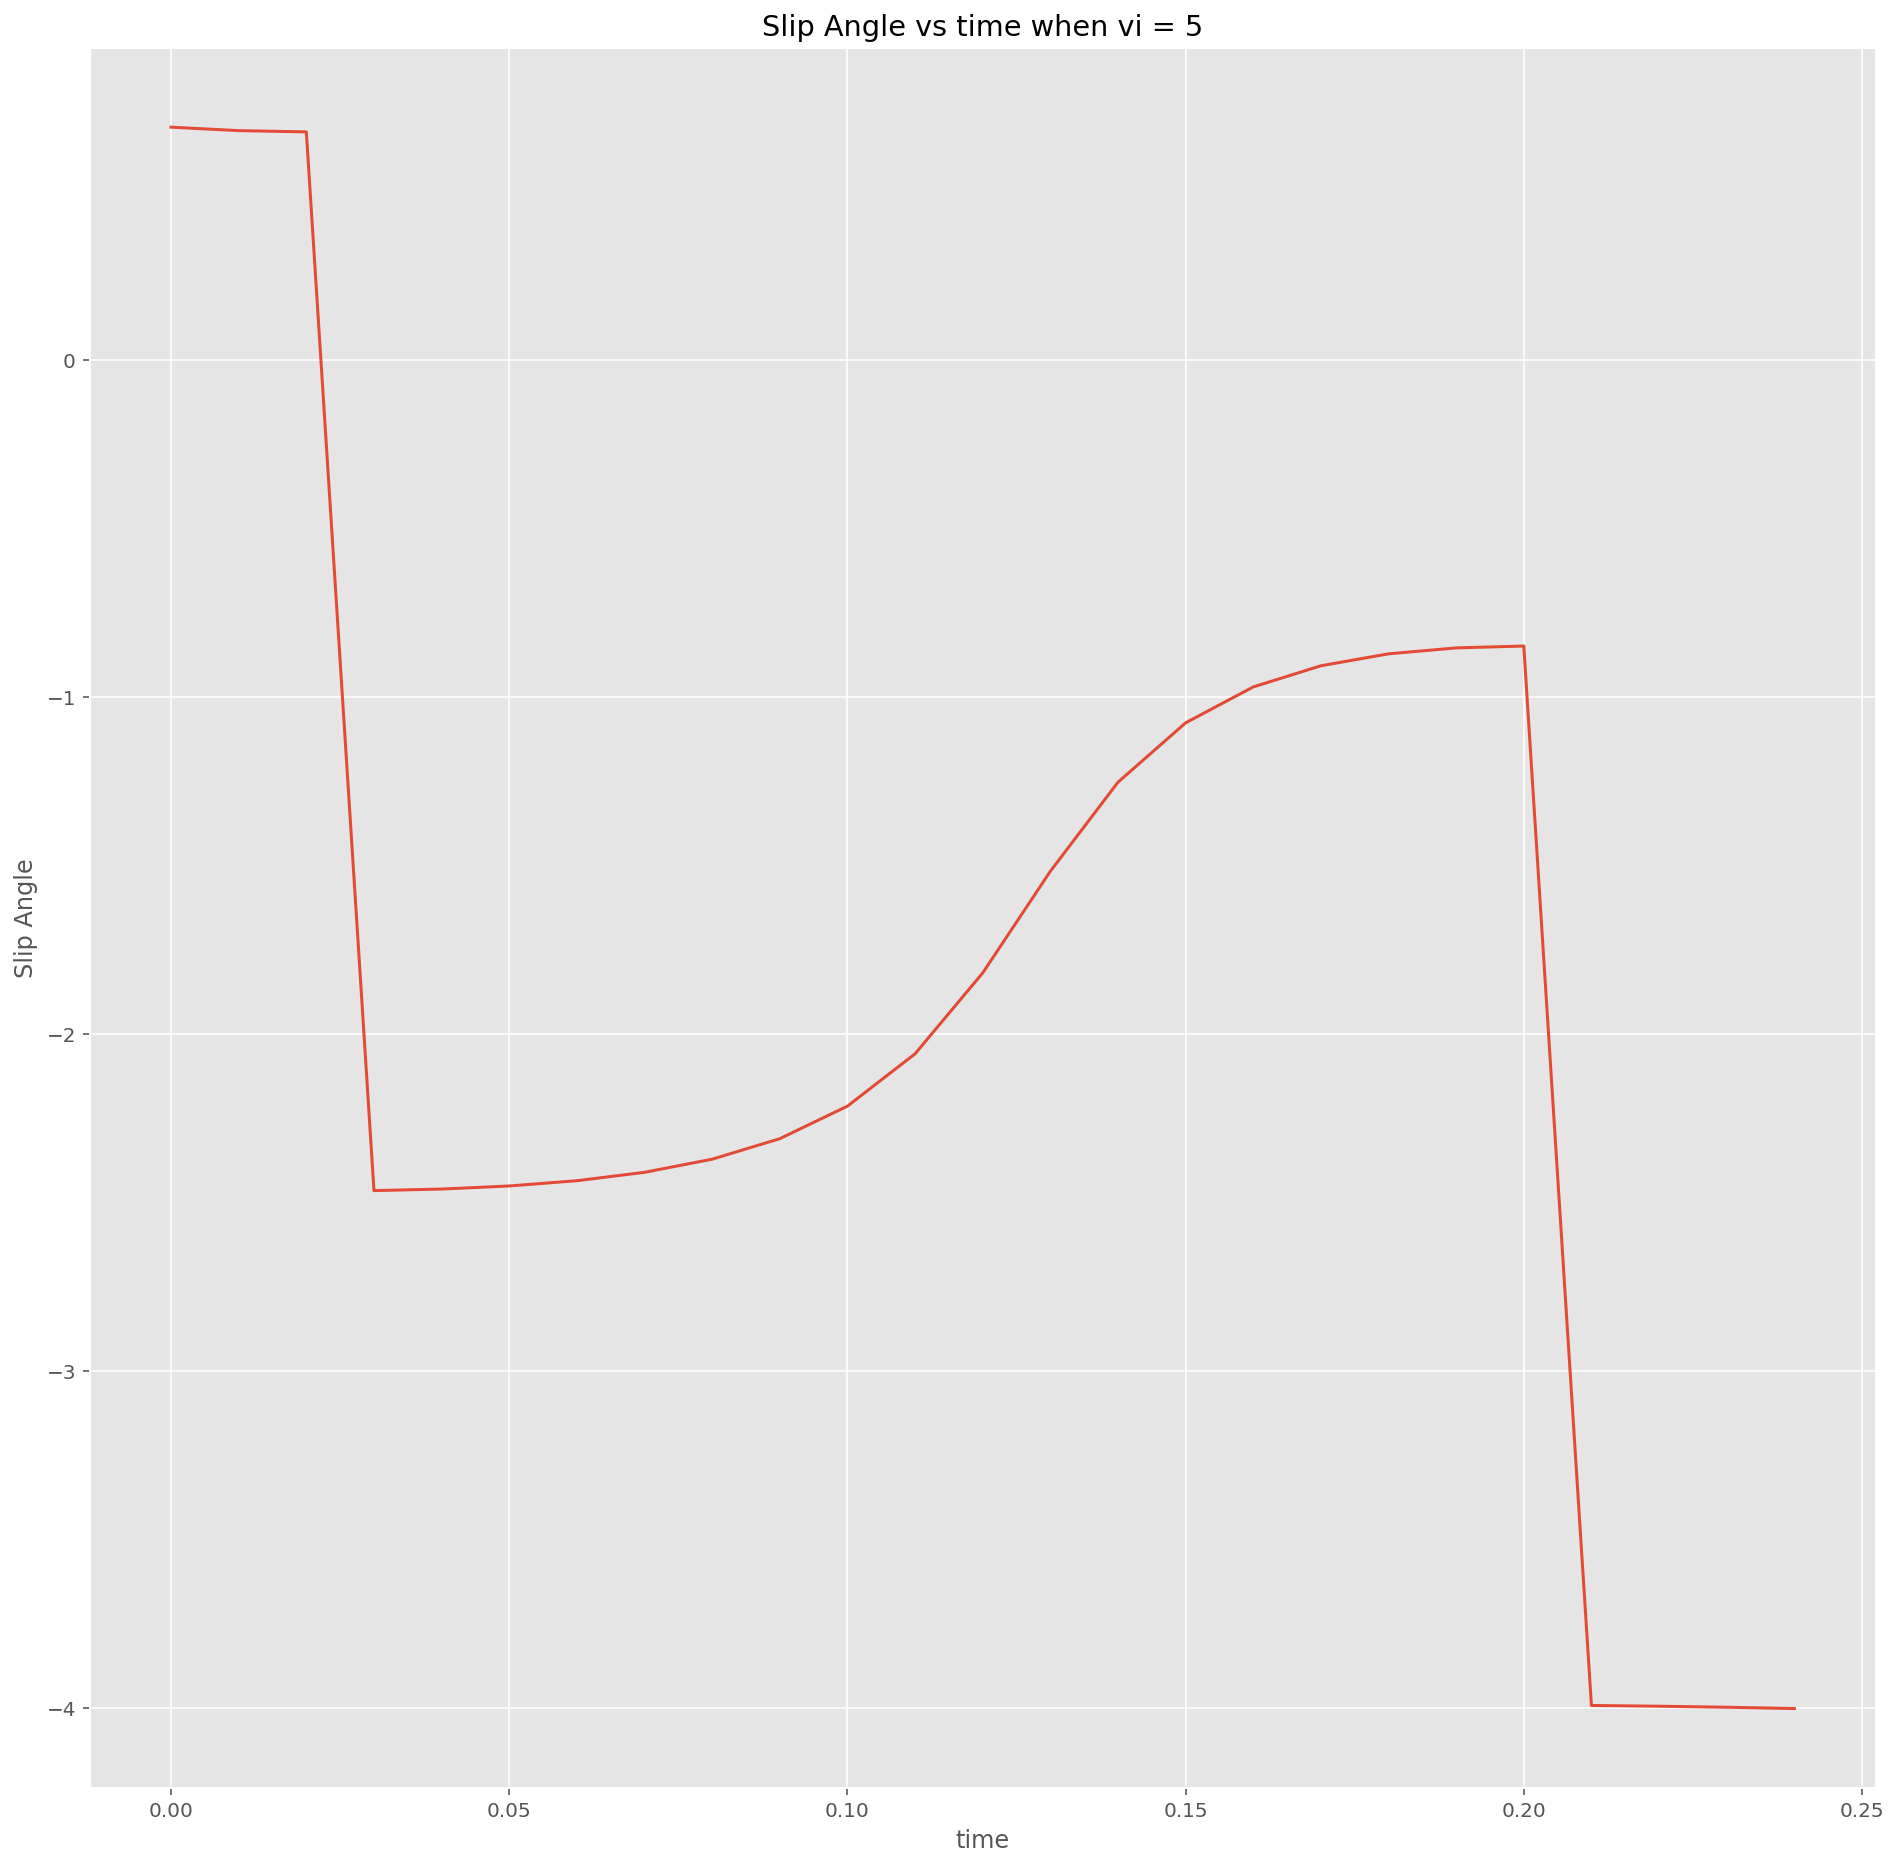

In [31]:
plt.figure()
plt.plot(t0_1BURB, delta(v0_1BURB,alpha0_1BURB))
plt.xlabel('time')
plt.ylabel('Slip Angle')
plt.title('Slip Angle vs time when vi = 5')

Text(0.5, 1.0, 'Velocity vs time')

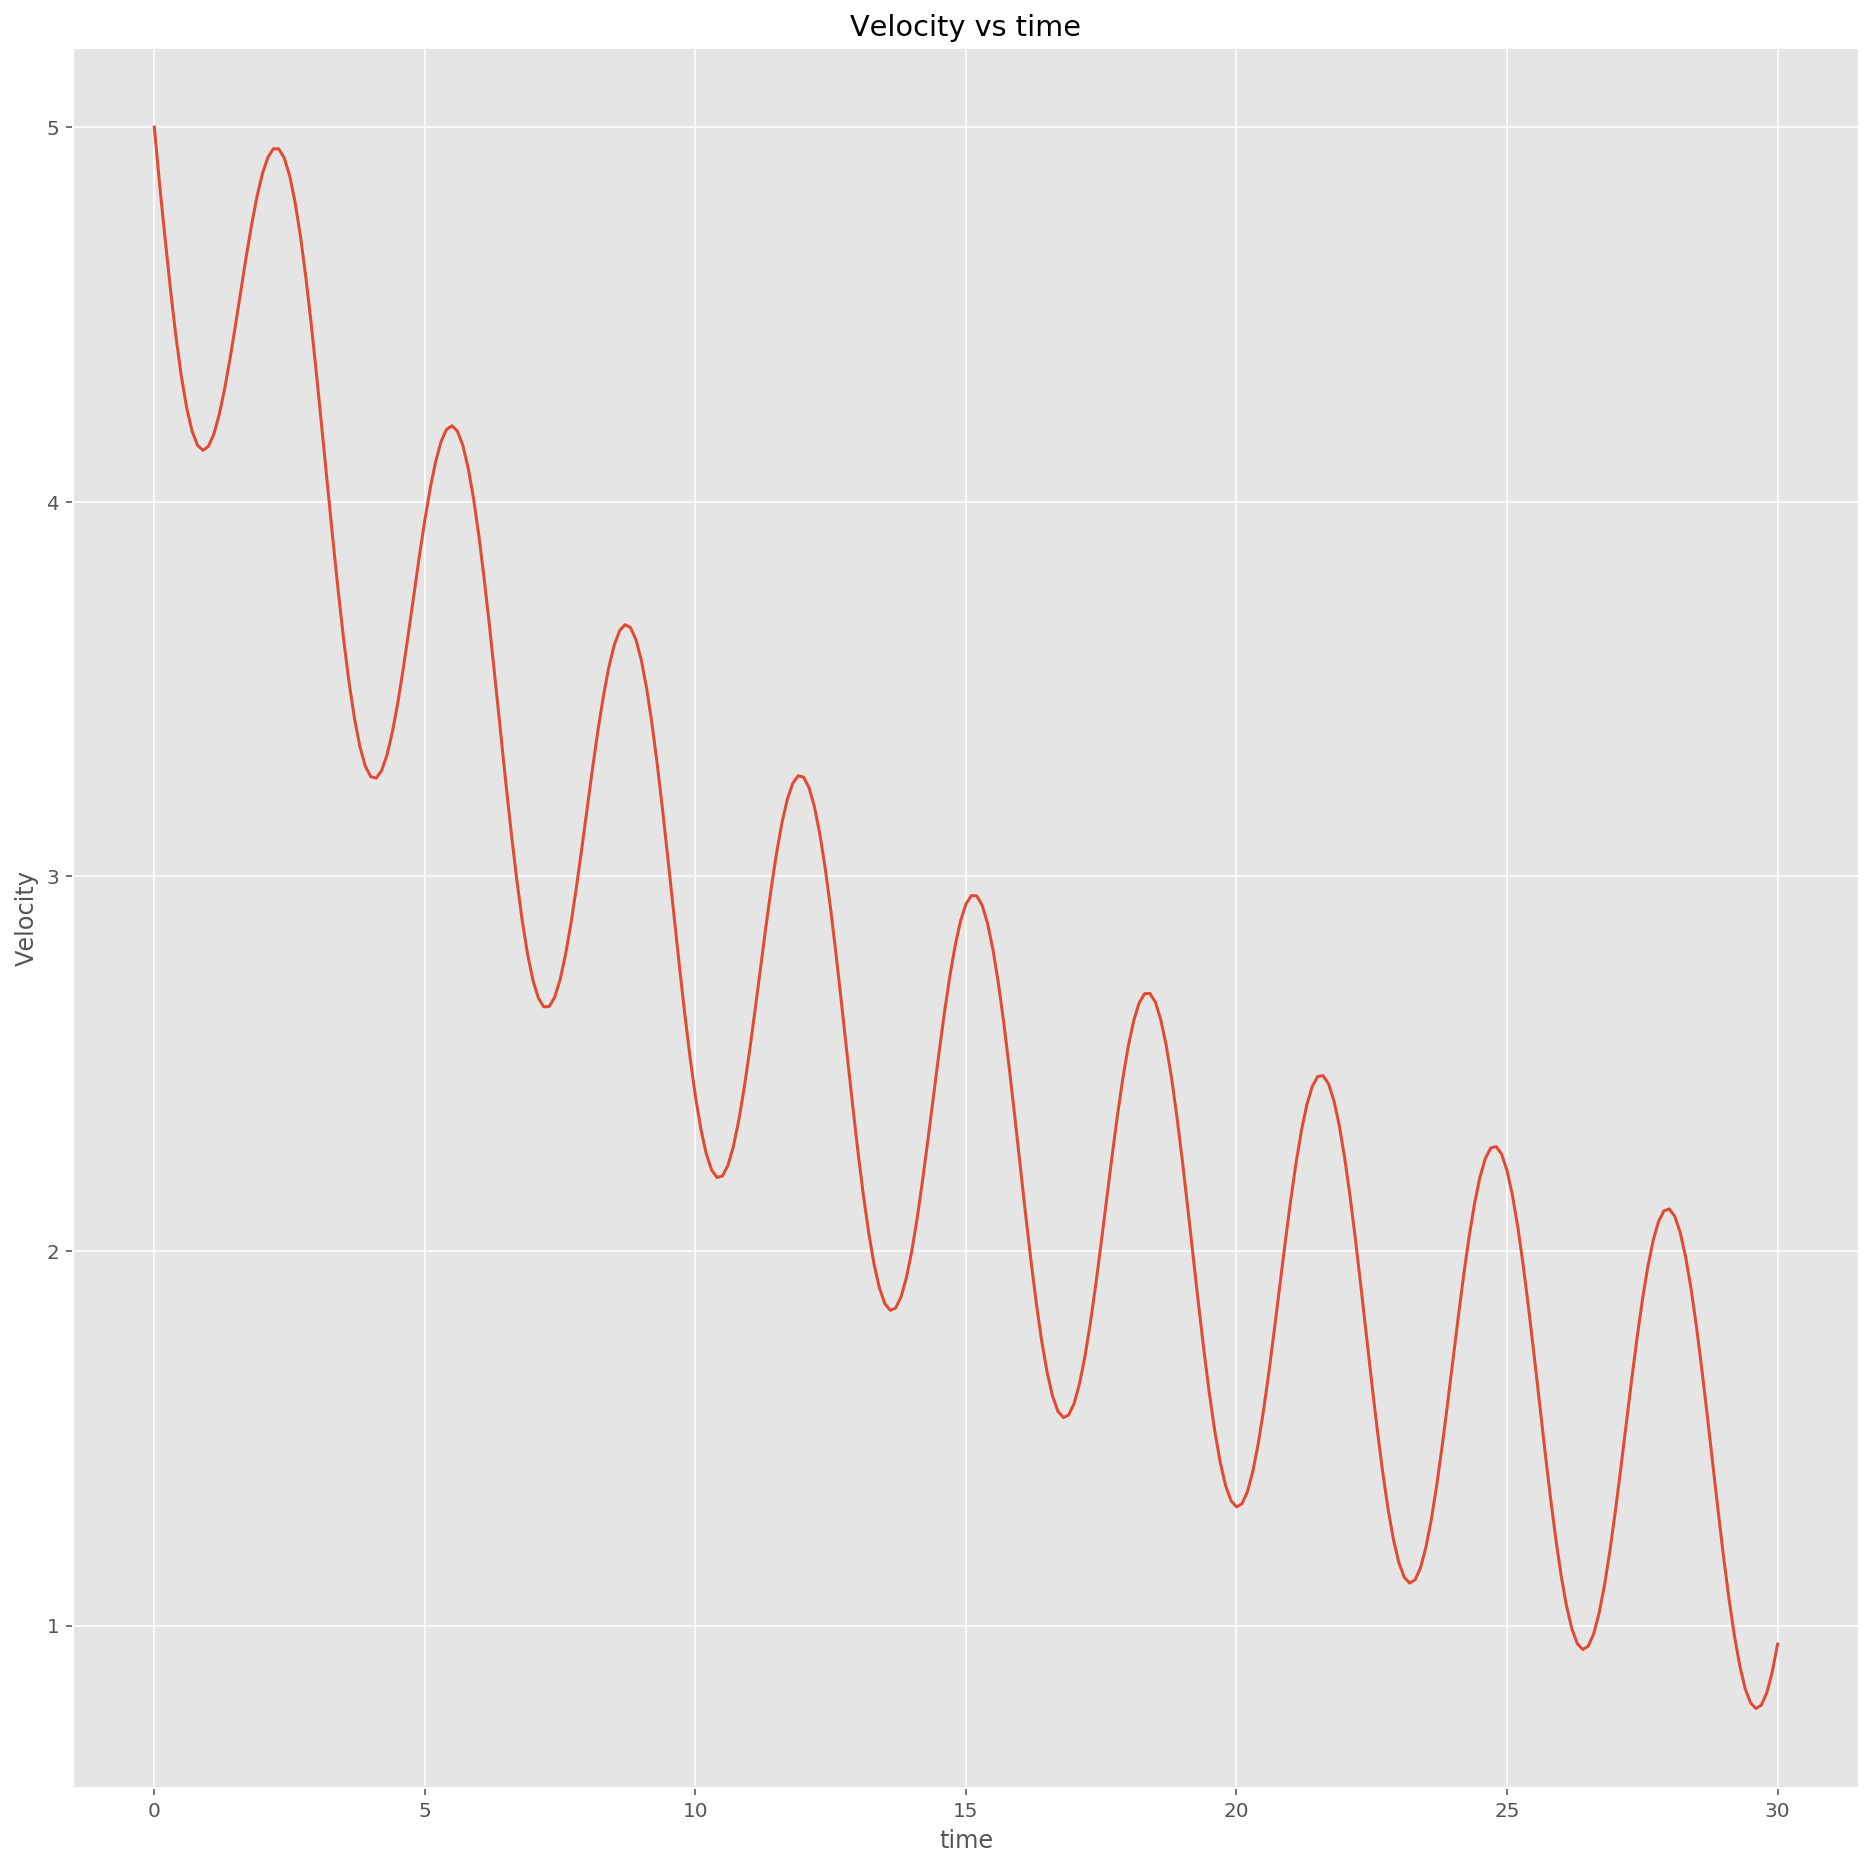

In [32]:
plt.figure()
plt.plot(t0BURB, v0BURB)
plt.xlabel('time')
plt.ylabel('Velocity')
plt.title('Velocity vs time')

Text(0.5, 1.0, 'Energy vs time')

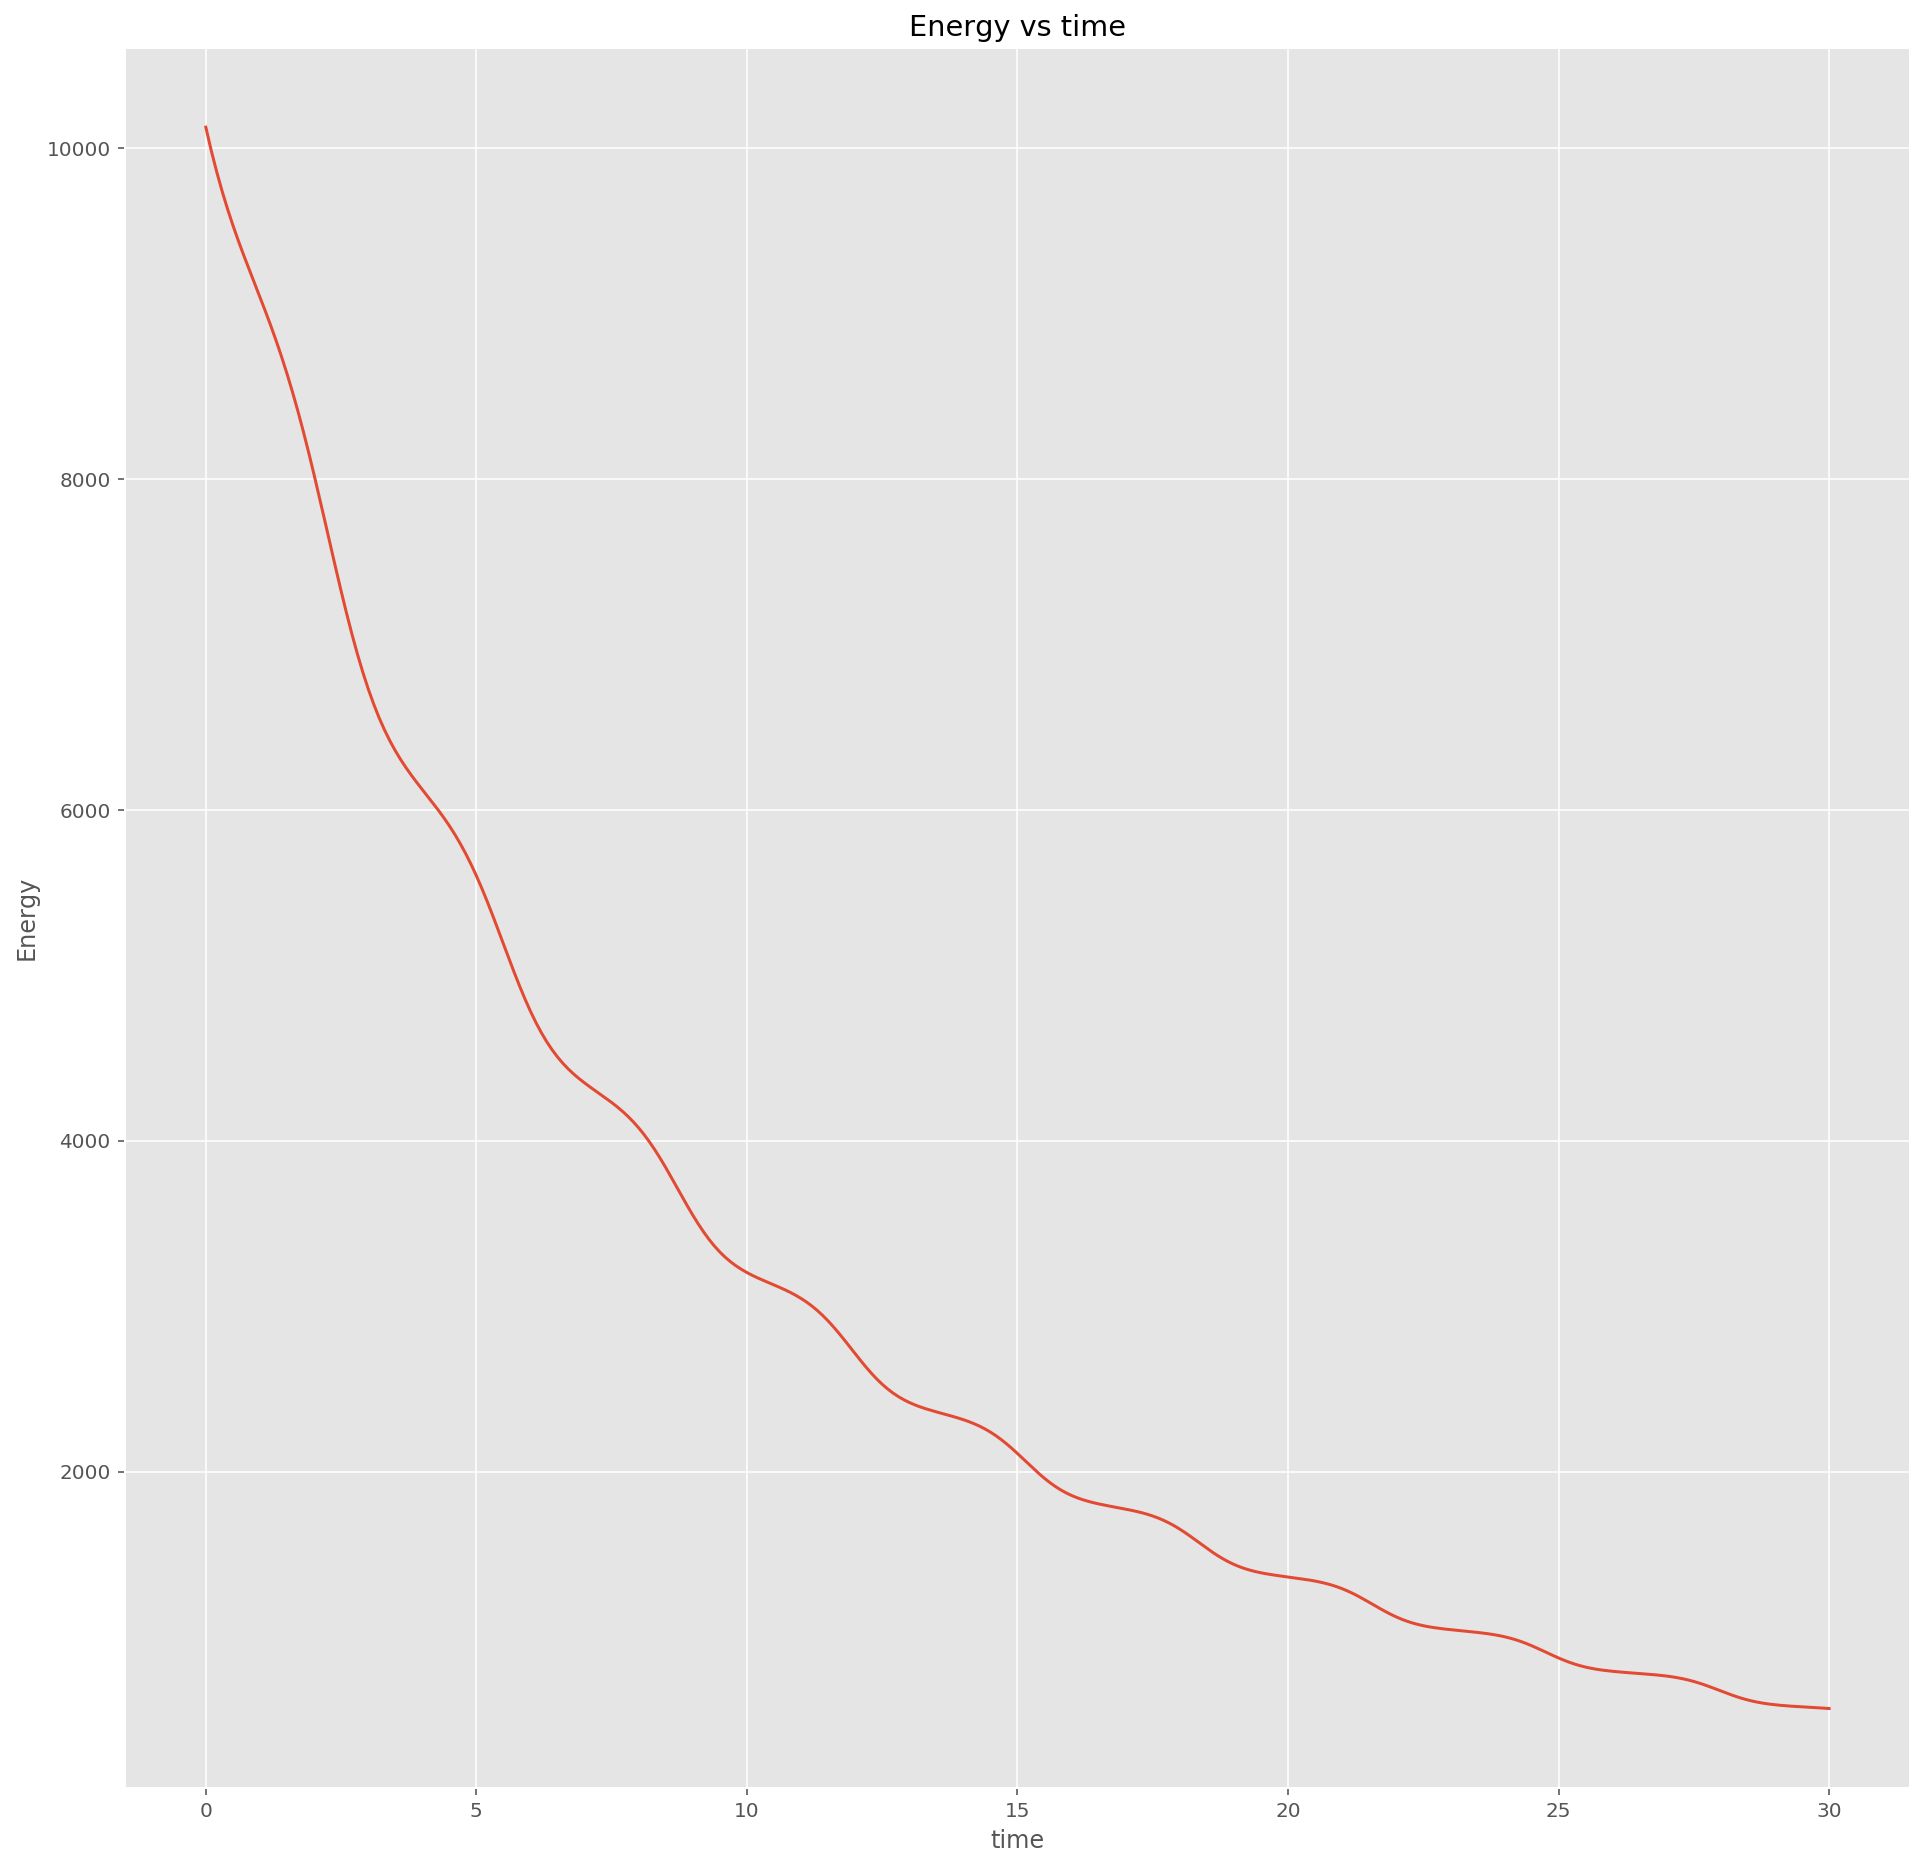

In [33]:
plt.figure()
plt.plot(t0BURB,(energy0BURB))
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Energy vs time')

### Discussion
There are a multitude of aspects to this project the require discussion. I would like to discuss the validity of the model alone and then delve into the various power curves and what the model tells us about the effectiveness. Lastly, I would like to reflect on the successes and failures of the project and discuss my goals for future additions and research. As I touched upon in the introduction, this model is inherently flawed. Gaps in the knowledge about the forces in rowing stem from a general lack of funding due to the economic viability of funding such a niche sport. Thus, specific parameters such as the drag and lift coefficients are simply unknown and are generated through my own research and intuition. Additionally, outside / lesser forces like wind resistance, the temperature of water or any number of small forces are entirely neglected. That is not to say that these small pitfalls are the cause for the shortcomings of my model. Certainly, one cannot scapegoat the wind to justify a nonsensical result. Thus, I will do my best to speculate where these errors stemmed from and how I attempted to address them. First off, the data appears to be inverted. There is no logical reason for which the velocity should every be negative, additionally, given the input of power the velocity certainly should not decay exponentially. Having played with the signs in the dvboatdt as well as all of the standard functions I still cannot say specifically where the problem lies. I do not think that the model is entirely wrong, however, as by simply inverting and then shifting the model up the graphs for the velocity and energy match our intuition as is seen below: 

Text(0.5, 1.0, 'Velocity vs time')

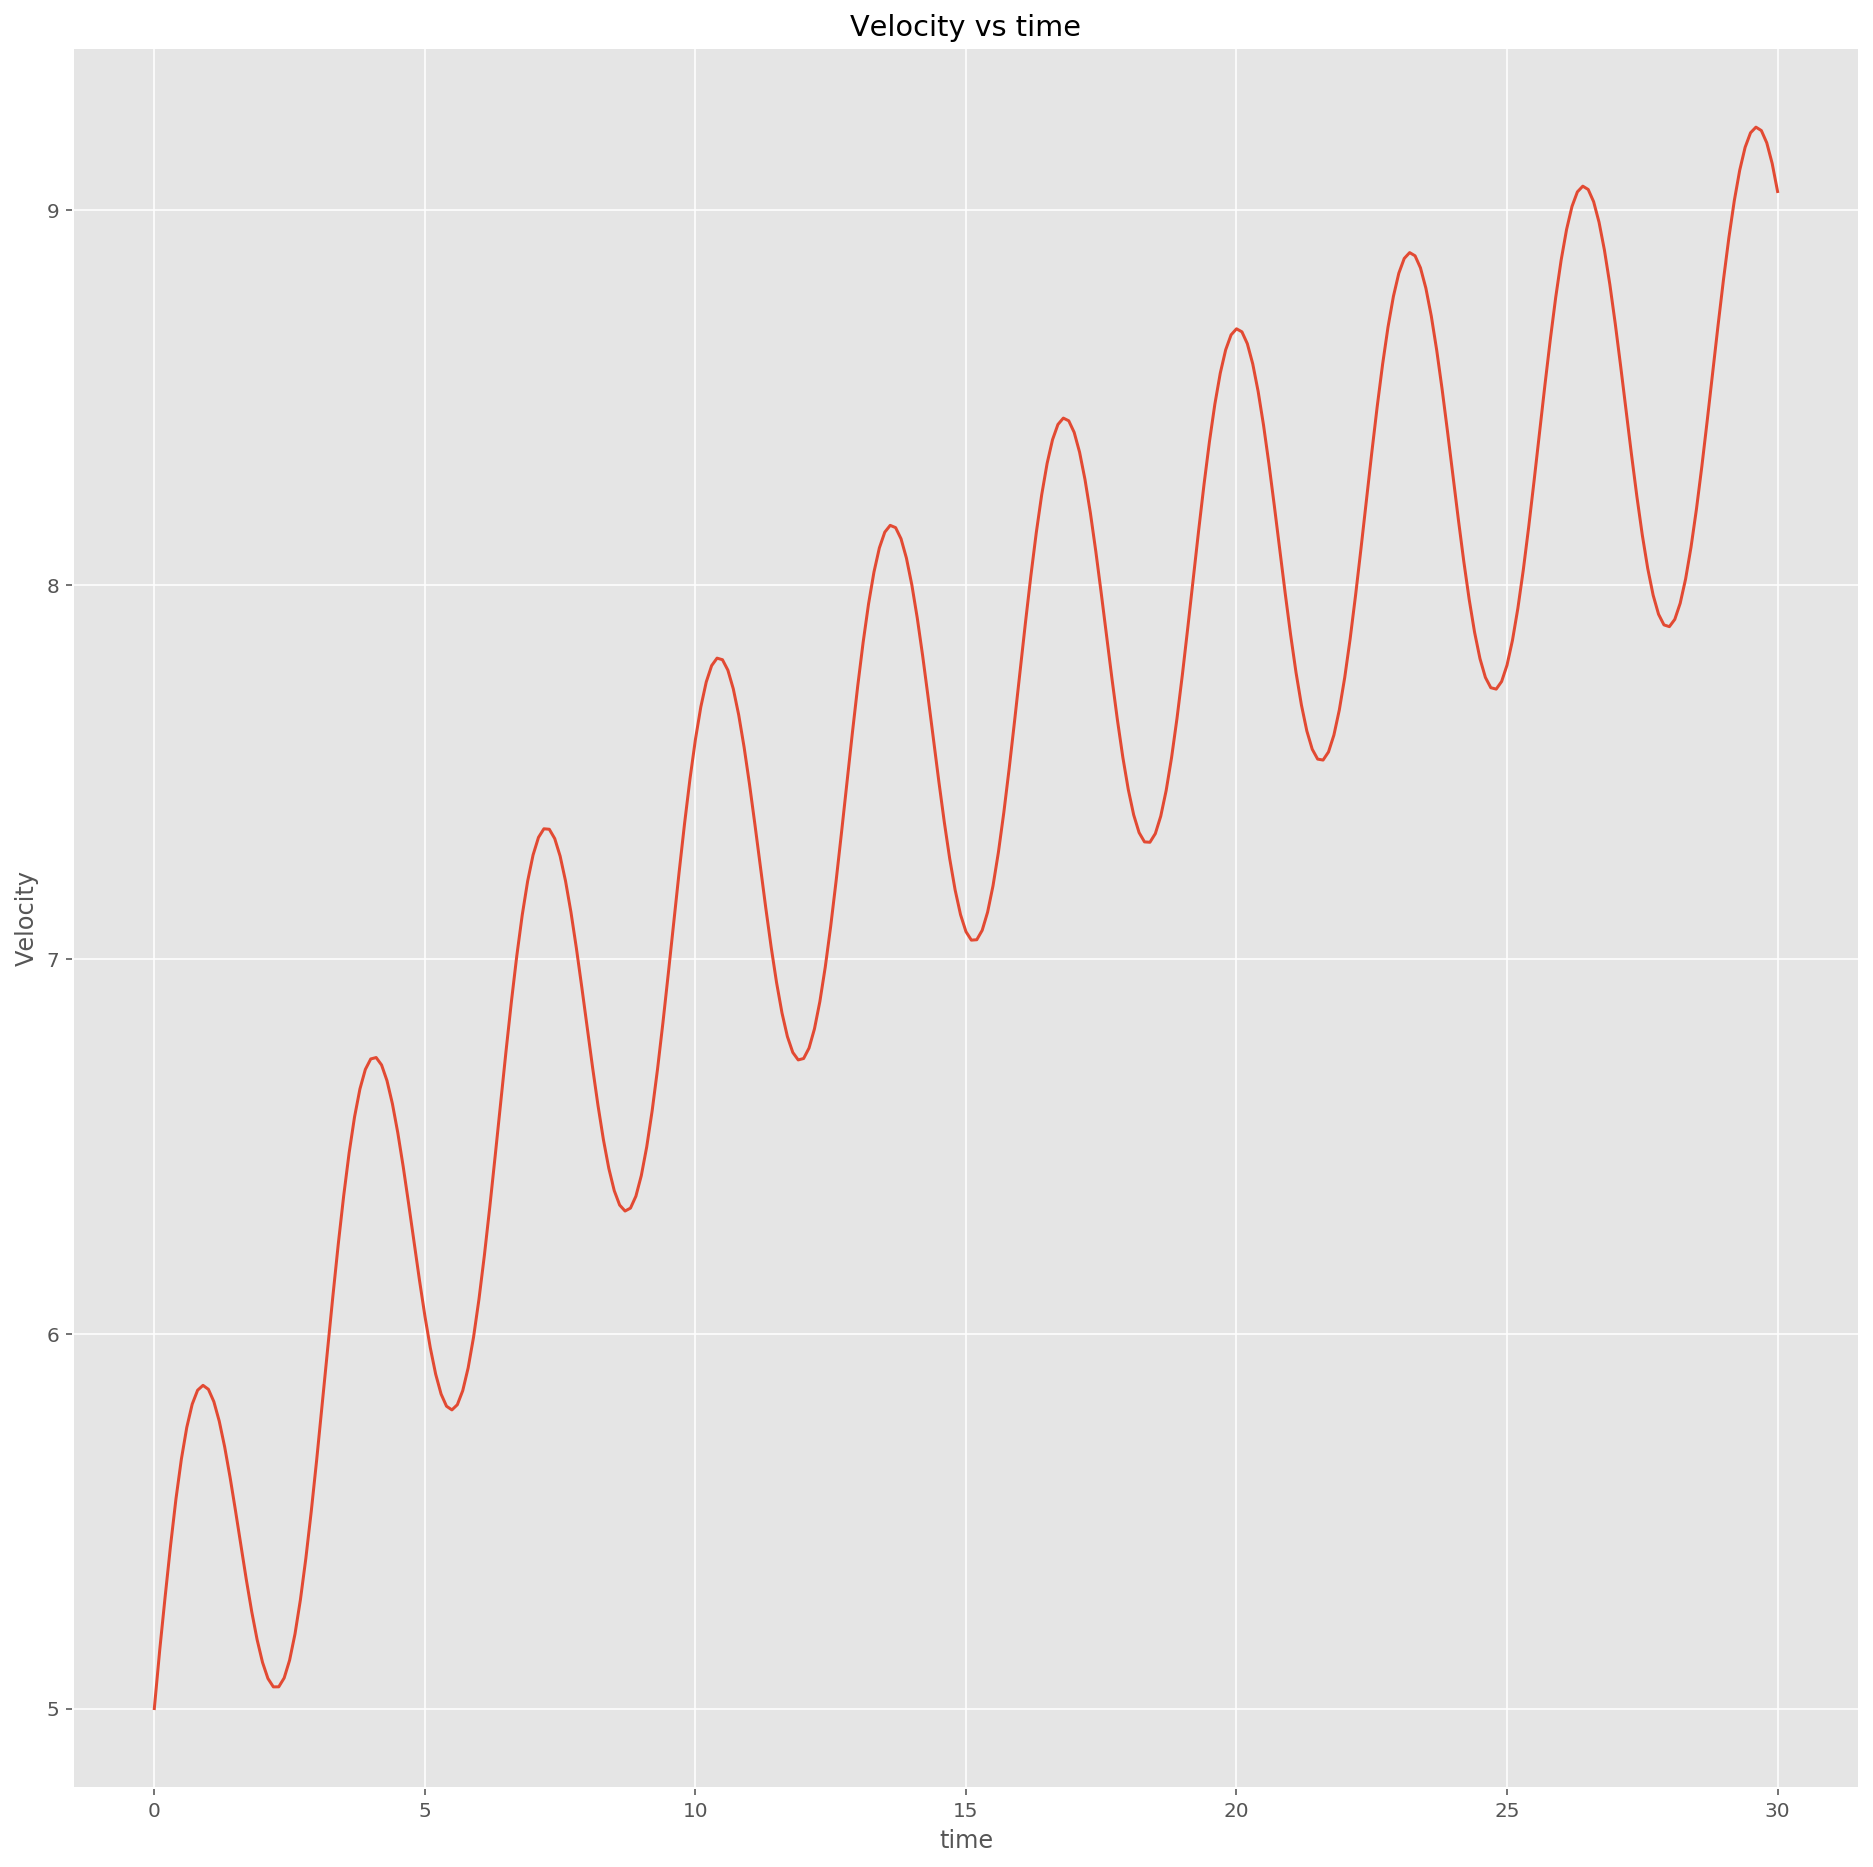

In [34]:
plt.figure()
plt.plot(t0, -v0 + 10)
plt.xlabel('time')
plt.ylabel('Velocity')
plt.title('Velocity vs time')

Text(0.5, 1.0, 'Energy vs time')

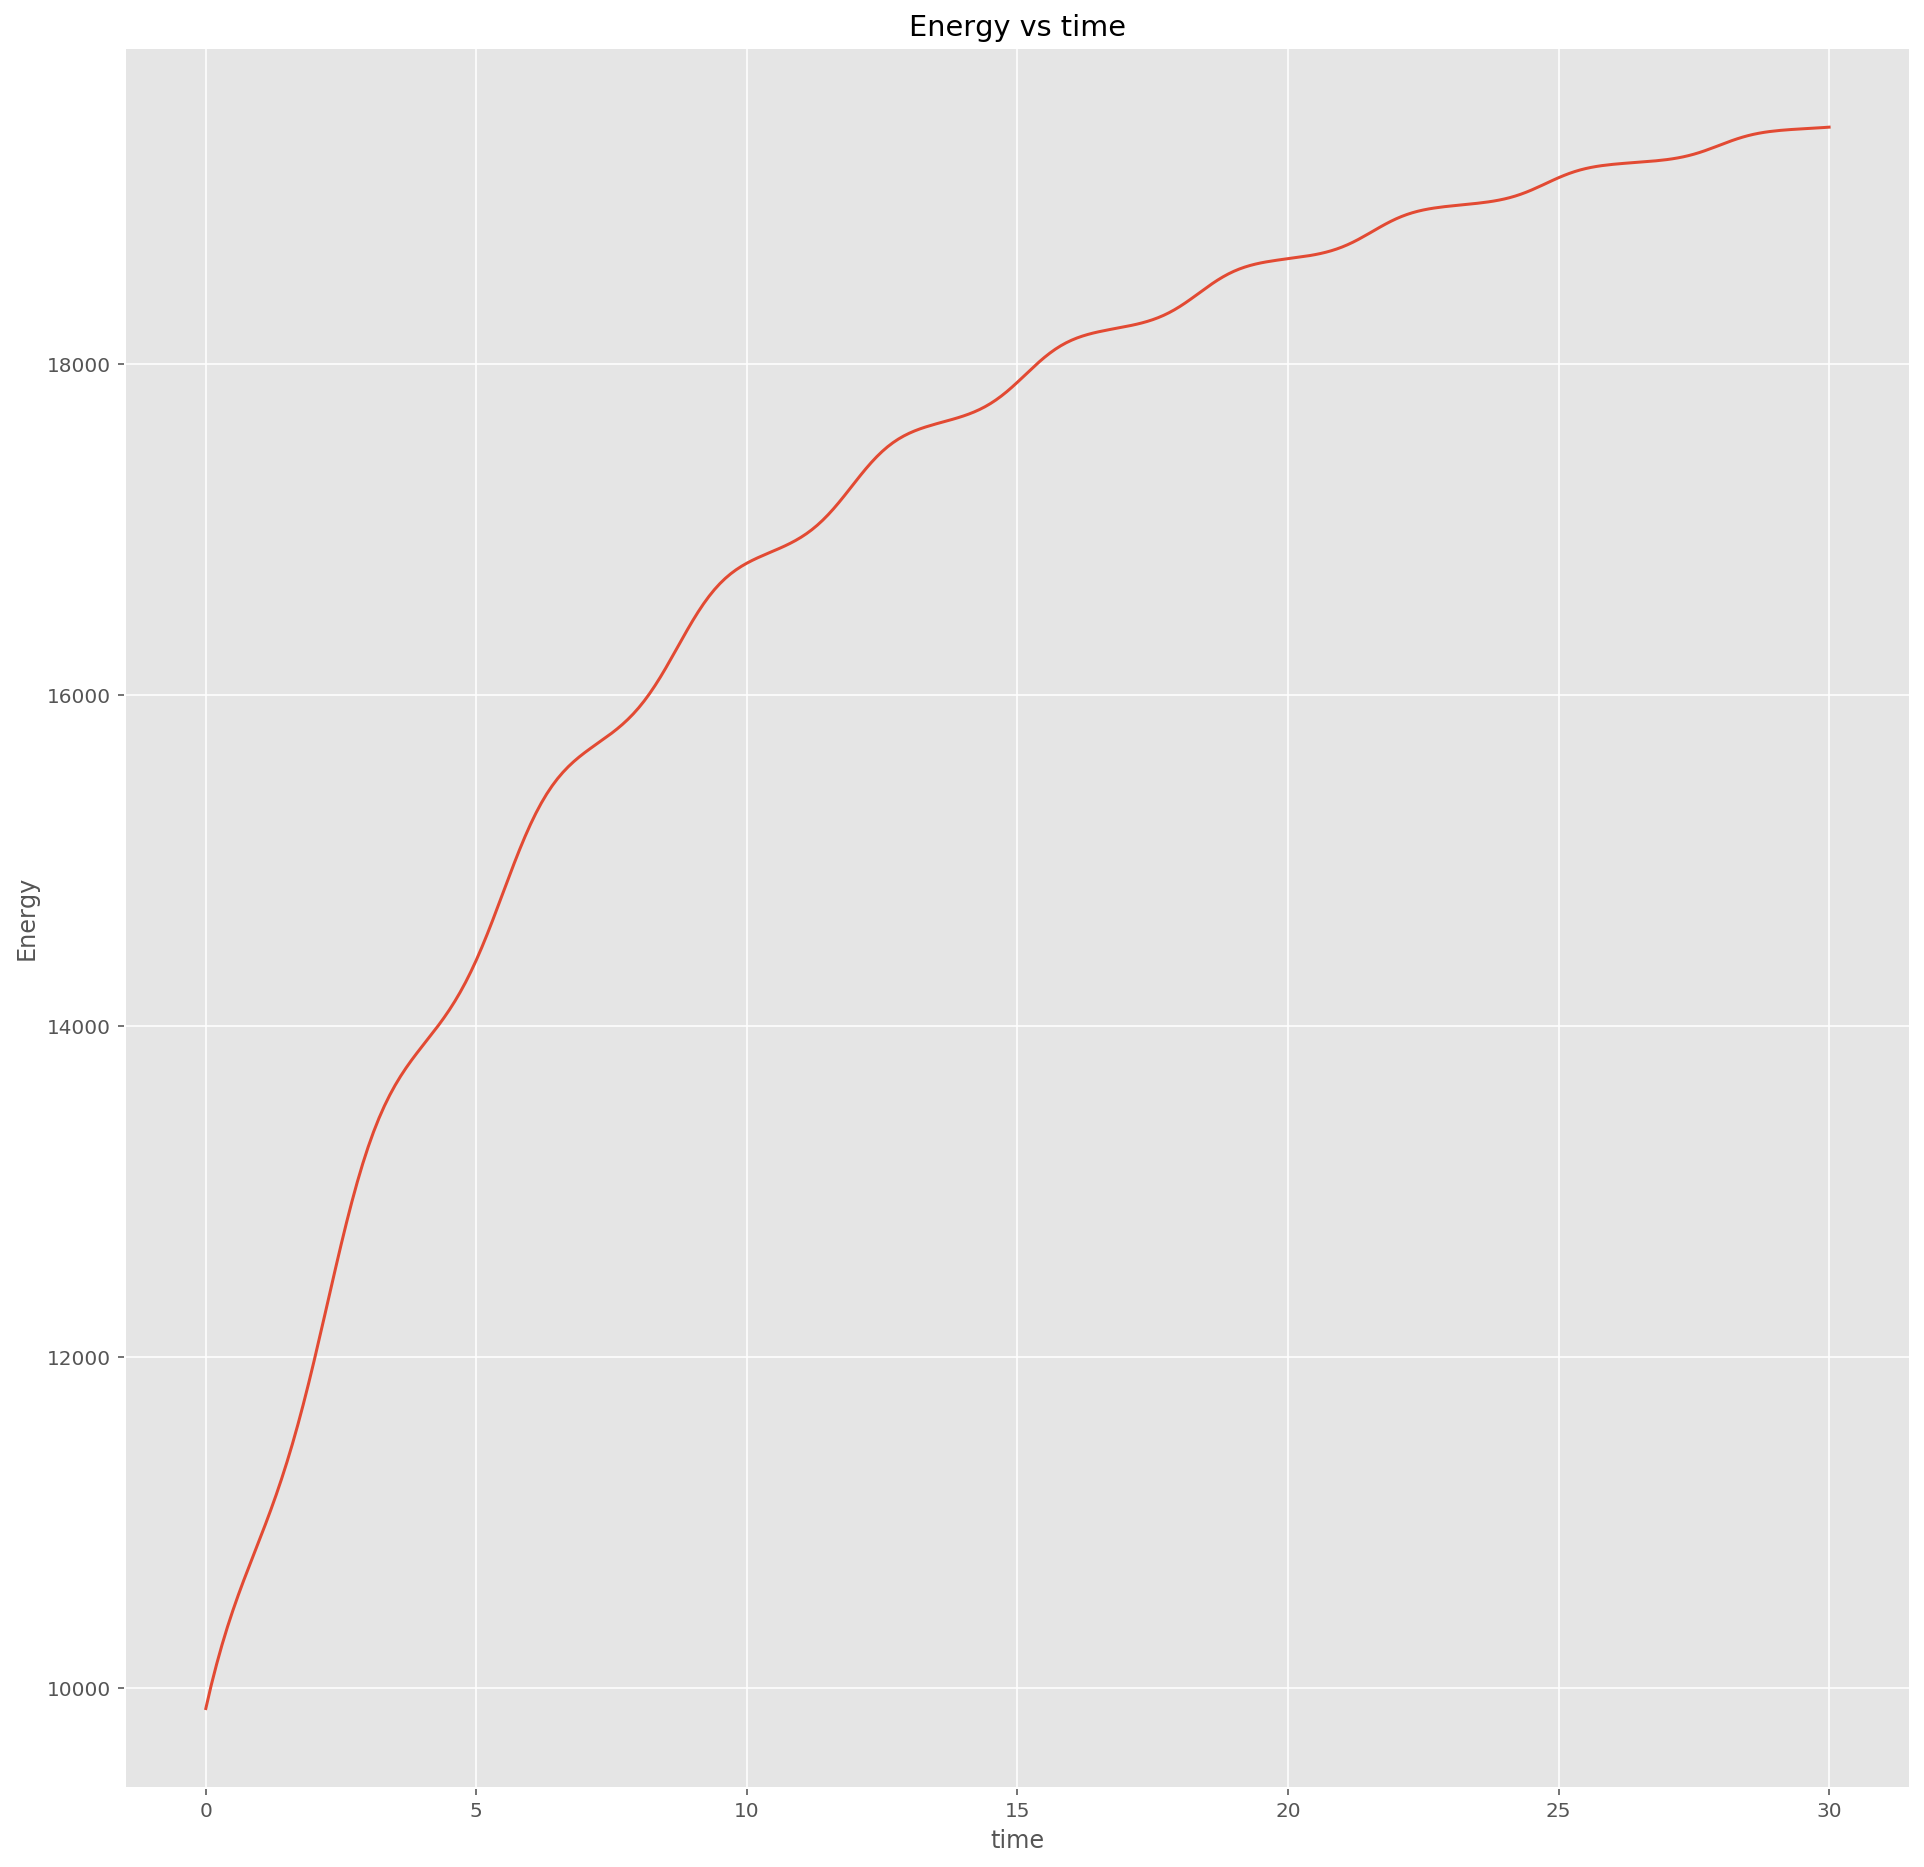

In [35]:
plt.figure()
plt.plot(t0,(-energy0) + 20000)
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Energy vs time')

The fact that these inverted and shifted graphs resemble what we would expect so closely would suggest that mearly a sign error exists somewhere within the model and not that the model is wrong altogether. Unfortunately, having not been able to find this error I cannot point to it nor prove that it necesarily exists. 

Certainly the most dissapointing aspect of this project is the fact that running the power curves that I created through my function did not produce any tangible results. At this point I am unsure, where specifically the problem lies. Having adressed the issue of the power curves not being constrained to the alpha initial and final conditions I assumed that I would receive tangible outputs. To my dismay, running these different power curves through my function does not yield any different results. I have a few theories as to why this may have occured. First, the only place in which the power functions are called upon is in the differential equation for energy. Additionally, unlike the velocity and angular acceleration, energy is not called upon in any of the functions above. Thus, we cannot expect to see its impact outside of energy. We can acknowledge that and move on as the impact of these force curves should still show up in the output of our rkdriver for energy. To my dismay, the energy outputs for all of the force curves are identical. Assuming that the way that I reconstructed the mathematical model is not flawed then there are a few logical extensions that can be made. One such extension is that mathematically the shape of the power curve is irrelevent assuming that the total area under the curve remains constant. This seems to be unlikely for two reasons. First, the likelyhood of my model neglecting something is very high. Second, if the former were not true then the model would imply that power curves do not matter which we know from experimental data to be untrue. Thus, there must be a flaw somewhere in my model that is preventing these functions from generating realistic outputs. There are a few things that I had hoped my power curves would have illustrated. The rectangular function, despite being the most mechanically efficient model of applying power should have yielded a lower average boat velocity. This would illustrate the fact that although it is more mechanically efficient to output energy in this manner, it takes time for the pressure of the water on the face of the blade to build and thus the angle of attack would be mutch larger which would cause excessive washing out and less force being utilized. Similarly, with the Burb curve, I wanted to illustrate the fact that the second hump in the power curve caused a dissipation of connection with the water and thus resulted in slower boat speeds. The fact that the output of the model does not change regardless of power curve input is quite frustrating and clearly indicative of a larger error. The relationship between the power and the angular acceleration and the velocity of the boat seems to only work one way. Power is a function of alpha and thus the angular acceleration is considered in the output of Energy, however, neither alpha nor the velocity of the boat are dependent on the energy. Thus, we would not expect to see its impact in the final velocity of the boat. This does not make logical sense in the context of rowing which suggests that the model itself is flawed.

I would like to conclude this paper by discussing my goals and interests for future research and discuss my thoughts on the project as a whole. This project fascinates me to no end, and I would like to continue to develop this model such that it can viably be used to test how various parameters impact boat speed. First, I believe the EOMROW needs to be tweaked, whether that means finding the sign error that exists, or altering it all together. Additionally, I would like to spend more time researching airfoil theory and how we can relate findings within that field back to oar blades and generate more accurate functions for cL and cD. From there I would like to conduct the tests that I originally intended on conducting in this project. I would like to prove the efficacy of power curves that are collectively thought of as being optimal. Finally, optimization and machine learning has been something that has piqued my interest. It would be very interesting to develop a program that could produce an optimized force curve. This project was extremely challenging for me and despite the shortcomings of my model I am very proud of this project.

This project is entirely based upon the work of Elke Ottenhoff. The mathematical model of the rowing stroke that he developed served as the basis for my functions and allowed me to create this model.
http://www.math.rug.nl/~veldman/Scripties/Ottenhoff-afstudeerverslag-ingenieur.pdf